Table of Contents

Vento ( wind_speed, wind_speed_hor, u, v, w)

- [Filter by Wind Dir](#Filter-By-Wind-Dir)

    - [U TrsV -> interessante](#u-TrsV)

- [Filter by AoA](#Filter-By-AoA)

- [Filter by AoA and Dir](#Filter-By-AoA-AND-Dir)

Flussi

- [Fluxes](#Fluxes)



In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from wind_tools import *
import pandas as pd
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib
from windrose import WindroseAxes
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from itertools import product, cycle
#matplotlib.use('Qt5Agg')
from functools import lru_cache
import matplotlib.pyplot as plt
sns.set(style='whitegrid')
import plotly.express as px

matplotlib.rcParams['figure.figsize'] = (12,10)

# Load High Freq data

In [ ]:
import matplotlib.font_manager

In [ ]:
matplotlib.rcParams['font.sans-serif'] = "Open-Sans"

In [ ]:
date_range = "index > '2020-08-13'"

In [ ]:
in_dir = Path('2020_data/data_field_v2_from_20208010/preprocessed/')
names = [
    '*_WM_174605_com1.csv',
     "*_TRS_M00506_com3.csv",
    "*_TRS_M00507_com2.csv",
]

In [ ]:
def maybe_interpolate(df, max_tol=0.1):
    if df.iloc[:, 0].isna().sum() < len(df)*max_tol:
        return df.interpolate()
    else:
        print("not enough data")
        return df

In [ ]:
def make_long_df(name_re):
    return pd.concat([maybe_interpolate(load_high_freq_data(f)) for f in in_dir.glob(name_re)])

In [ ]:
wm1, TrsH, TrsV = map(lambda x: make_long_df(x)
                  .query(date_range)
                  .pipe(maybe_interpolate)
                  .pipe(add_wind_dir)
                  .pipe(add_wind_speed)
                  .pipe(add_angle_attack)
                  .pipe(add_hor_wind_speed),
                  names)

In [ ]:
plot_info_all=[{'label': 'WM1', 'color': sns.color_palette()[0]}, {'label': 'TrsH', 'color': sns.color_palette()[1]}, {'label': 'TrsV', 'color': sns.color_palette()[2]}]
plot_info_m7 = [{'label': 'WM1', 'color': sns.color_palette()[0]}, {'label': 'TrsV', 'color': sns.color_palette()[2]}]

## Calc Dir and AoA stats

In [ ]:
wm1_good_dir = filter_by_wind_dir(wm1, 250, 30).resample('30min').sum() / 18000

In [ ]:
wm1_good_dir

2020-08-13 00:00:00    0.419167
2020-08-13 00:30:00    0.323333
2020-08-13 01:00:00    0.273611
2020-08-13 01:30:00    0.266333
2020-08-13 02:00:00    0.171500
                         ...   
2020-08-27 06:30:00    0.180444
2020-08-27 07:00:00    0.070333
2020-08-27 07:30:00    0.121778
2020-08-27 08:00:00    0.173556
2020-08-27 08:30:00    0.176667
Freq: 30T, Name: wind_dir, Length: 690, dtype: float64

In [ ]:
wm1_good_aoa = ((wm1.angle_attack > -30) & (wm1.angle_attack < 30)).resample('30min').sum() / 18000

In [ ]:
wm1_good_aoa

2020-08-13 00:00:00    0.785778
2020-08-13 00:30:00    0.735389
2020-08-13 01:00:00    0.664222
2020-08-13 01:30:00    0.806444
2020-08-13 02:00:00    0.872056
                         ...   
2020-08-27 06:30:00    0.807444
2020-08-27 07:00:00    0.884278
2020-08-27 07:30:00    0.841500
2020-08-27 08:00:00    0.762389
2020-08-27 08:30:00    0.768833
Freq: 30T, Name: angle_attack, Length: 690, dtype: float64

## Load EP data

In [ ]:
proc_dir = Path("2020_data/data_field_v2_from_20208010/processed/30min")

ep_paths = ["eddypro_WM1_30min_full_output_2020-08-25T121604_exp.csv",
            "eddypro_M506_30min_full_output_2020-08-25T122305_exp.csv",
            "eddypro_TRS_M507_30min_full_output_2020-08-25T120431_exp.csv"]

dir_filt_dir = proc_dir / "../filt_dir_5min"
ep_paths_filt_dir_3m = ["eddypro_WM1_filt_dir_3min_full_output_2020-08-27T123821_exp.csv",
            "eddypro_M506_filt_dir_3min_full_output_2020-08-27T101313_exp.csv",
            "eddypro_TRS_M507_filt_dir_3min_full_output_2020-08-27T131041_exp.csv"]

dir_3min = proc_dir / "../3min"
ep_paths_3m = ["eddypro_WM1_3min_full_output_2020-08-27T160147_exp.csv",
            "eddypro_TRS_M507_3min_full_output_2020-08-27T153846_exp.csv"]

ep_paths_15m 

cache_dir = Path("data_cache")

wind_cols = ['u_unrot','v_unrot', 'w_unrot', 'wind_speed', 'wind_dir', 'Tau', 'H', 'air_temperature', 'u*']
wind_comp_rename = {'u_unrot': 'u', 'v_unrot': 'v', 'w_unrot': 'w', 'air_temperature': 't'}

In [ ]:
data_ep = {time: list(map(
    lambda p: load_ep_cache(dir_filt_dir / p, cache_dir= cache_dir)
    .query(date_range)
    .loc[:,wind_cols]
    .dropna()
    .rename(columns=wind_comp_rename),
    ep_paths_filt_dir_3m)) for time, (paths, parents) in zip(times) }

In [ ]:
wm1ep, TrsHep, TrsVep = map(
    lambda p: load_ep_cache(proc_dir / p, cache_dir= cache_dir)
    .query(date_range)
    .loc[:,wind_cols]
    .rename(columns=wind_comp_rename),
    ep_paths)

In [ ]:
filt_dir_ep = list(map(
    lambda p: load_ep_cache(dir_filt_dir / p, cache_dir= cache_dir)
    .query(date_range)
    .loc[:,wind_cols]
    .dropna()
    .rename(columns=wind_comp_rename),
    ep_paths_filt_dir_3m))

In [ ]:
ep_3m = list(map(
    lambda p: load_ep_cache(dir_3min / p, cache_dir= cache_dir)
    .query(date_range)
    .loc[:,wind_cols]
    .dropna()
    .rename(columns=wind_comp_rename),
    ep_paths_3m))

# Scatters

In [ ]:
def plot_one_scatter(dfs, col, plot_info, ax=None, title=None, **kwargs):
    x = dfs[0]
    ax = ax or get_ax()
    ax.plot(x[col],x[col], color='gray', label=f"theory", lw=1, linestyle='dashed')
    ax.set_xlabel("Wind Master")
    ax.set_ylabel("Trisonica")
    ax.set_title(col + " " + (title or ""))
    
    for i in range(len(dfs)-1):
        info = plot_info[i+1]
        y = dfs[i+1]
        
        ax.scatter(x[col], y[col], **info ,**kwargs)
        # do linear regression
        x_np = np.expand_dims(x[col].to_numpy(), -1) # adding empty dimension for sklearn    
        reg = LinearRegression().fit(x_np, y[col]) 
        r2 = reg.score(x_np,  y[col])
        pred_y = reg.predict(x_np)
        # plot actual regression line  
        ax.plot(x_np, pred_y, color=info['color'], label=f"{info['label']}, r^2: {r2:.2f}, slope: {reg.coef_[0]:.2f}")
    
    ax.legend()


In [ ]:
aggr_data = {time: [add_fluxes(df, time) for df in [wm1, TrsH, TrsV]] for time in ['3min', '5min', '10min', '15min', '30min', '60min']}

## Filters

In [ ]:
dir_filt = filter_by_wind_dir(wm1, 250, 30)

In [ ]:
aoa_filt = wm1.angle_attack.abs() < 30

In [ ]:
# when the aoa is outside teh TrsH range
    
not_good_aoa = {time: aoa_filt.resample(time).apply(lambda x: x.sum()/x.count() < .75) for time in ['3min', '5min', '10min', '15min', '30min', '60min']}

In [ ]:
for k in not_good_aoa:
    print(k, not_good_aoa[k].sum(), not_good_aoa[k].sum() / not_good_aoa[k].count())

3min 1588 0.2301449275362319
5min 890 0.21497584541062803
10min 377 0.1821256038647343
15min 221 0.16014492753623188
30min 89 0.1289855072463768
60min 33 0.09565217391304348


In [ ]:
unf_10m = [df.resample('10min').mean().dropna() for df in [wm1, TrsH, TrsV]]
filt_dir_10m = [df[dir_filt].resample('10min').mean().dropna() for df in [wm1, TrsH, TrsV]]
filt_aoa_10m = [df[aoa_filt].resample('10min').mean().dropna() for df in [wm1, TrsH, TrsV]]
filt_aoa_and_dir_10m = [df[aoa_filt & dir_filt].resample('10min').mean().dropna() for df in [wm1, TrsH, TrsV]]

/home/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


## All in One

In [ ]:
def add_H_flux(df, interval):
    res = df.resample(interval)
    H = np.zeros(len(res))
    for i, (_, data) in enumerate(res):
        H[i] = data.w.cov(data.t)
    ret = res.mean()
    ret['H'] = H
    return ret

In [ ]:
def add_tau_flux(df, interval):
    res = df.resample(interval)
    tau= np.zeros(len(res))
    for i, (_, data) in enumerate(res):
        tau[i] = np.sqrt(data.w.cov(data.u)**2 + data.w.cov(data.v)**2)
    ret = res.mean()
    ret['Tau'] = tau
    return ret

In [ ]:
def add_fluxes(df, interval):
    res = df.resample(interval)
    tau= np.zeros(len(res))
    H = np.zeros(len(res))
    for i, (_, data) in enumerate(res):
        tau[i] = np.sqrt(data.w.cov(data.u)**2 + data.w.cov(data.v)**2)
        H[i] = data.w.cov(data.t)
    ret = res.mean()
    ret['Tau'] = tau
    ret['H'] = H
    return ret

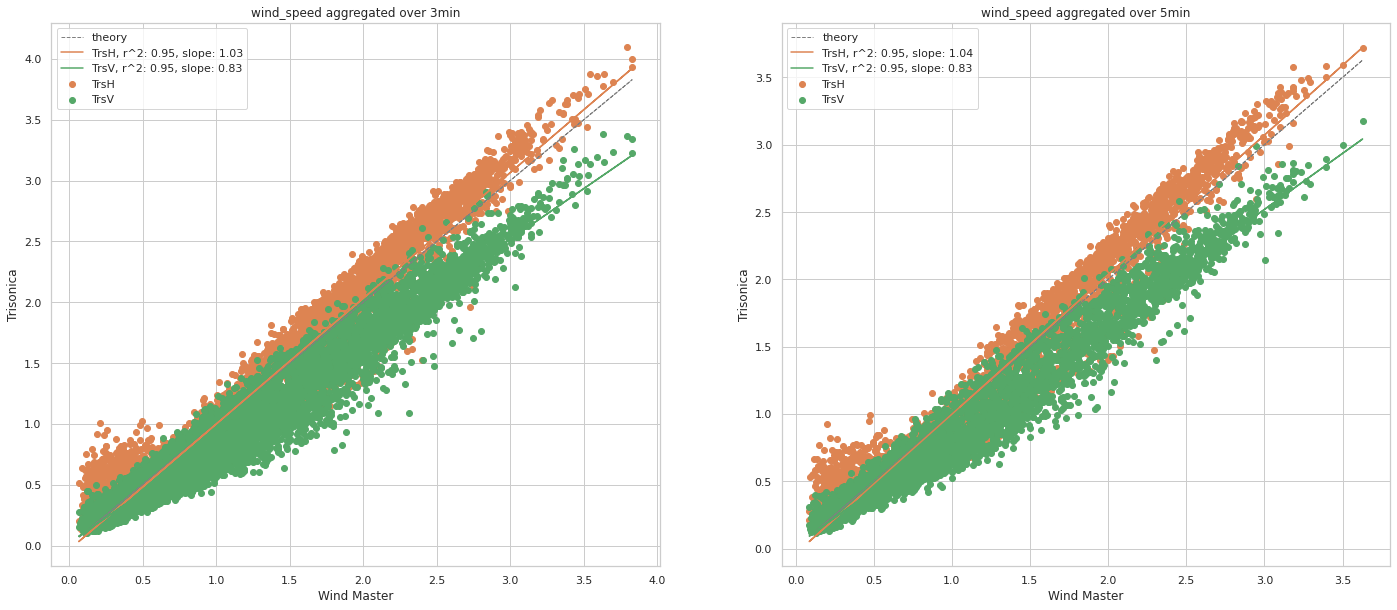

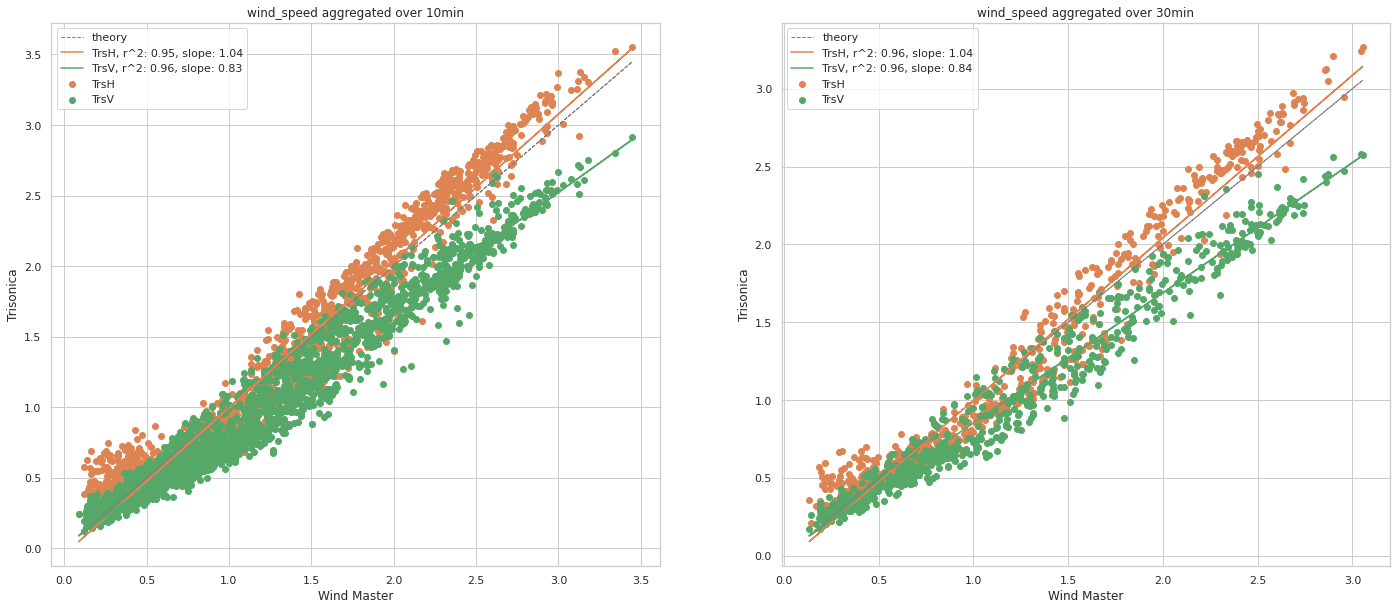

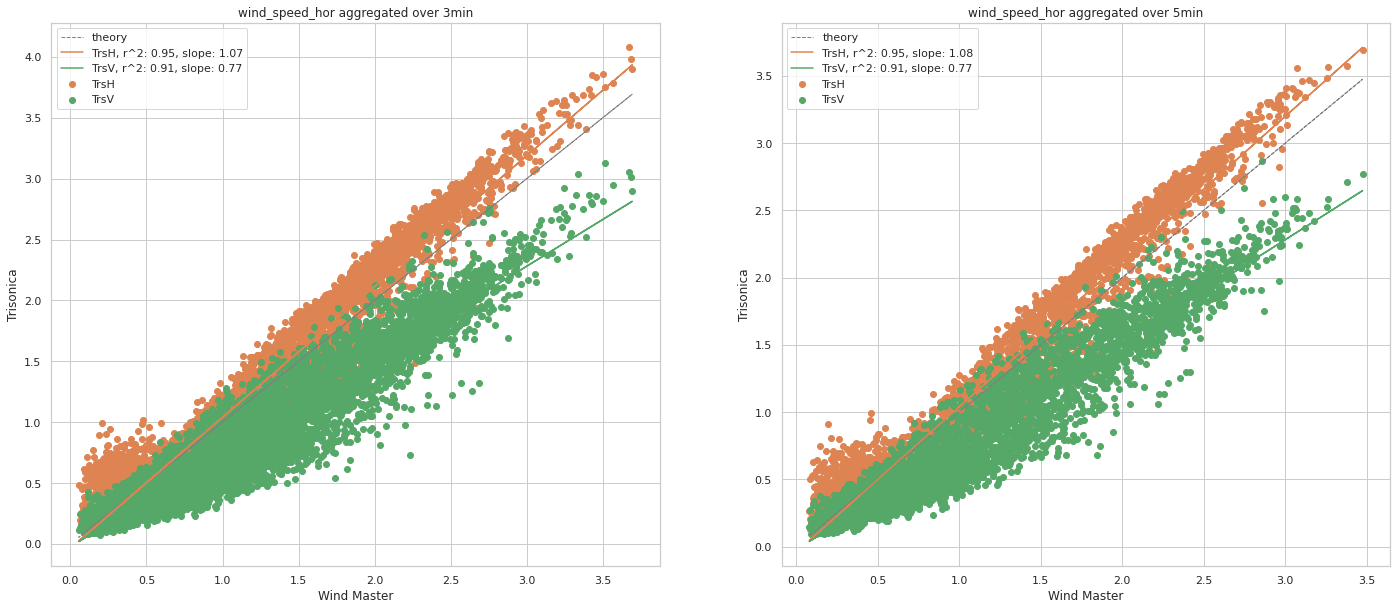

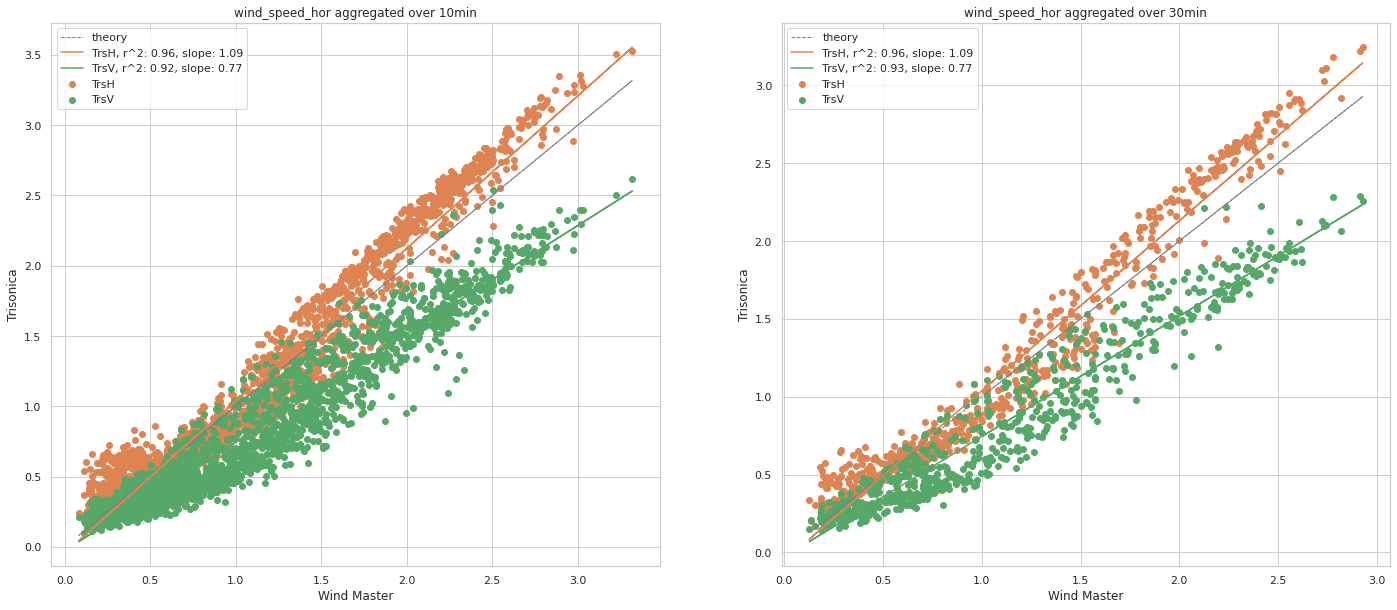

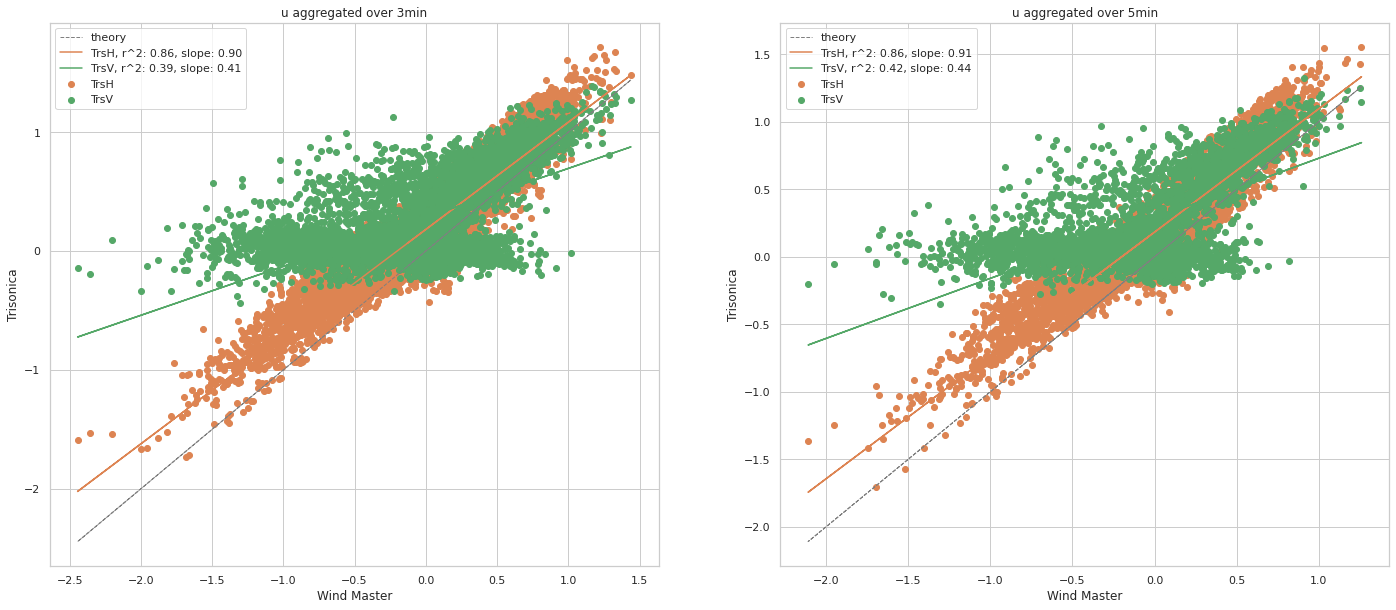

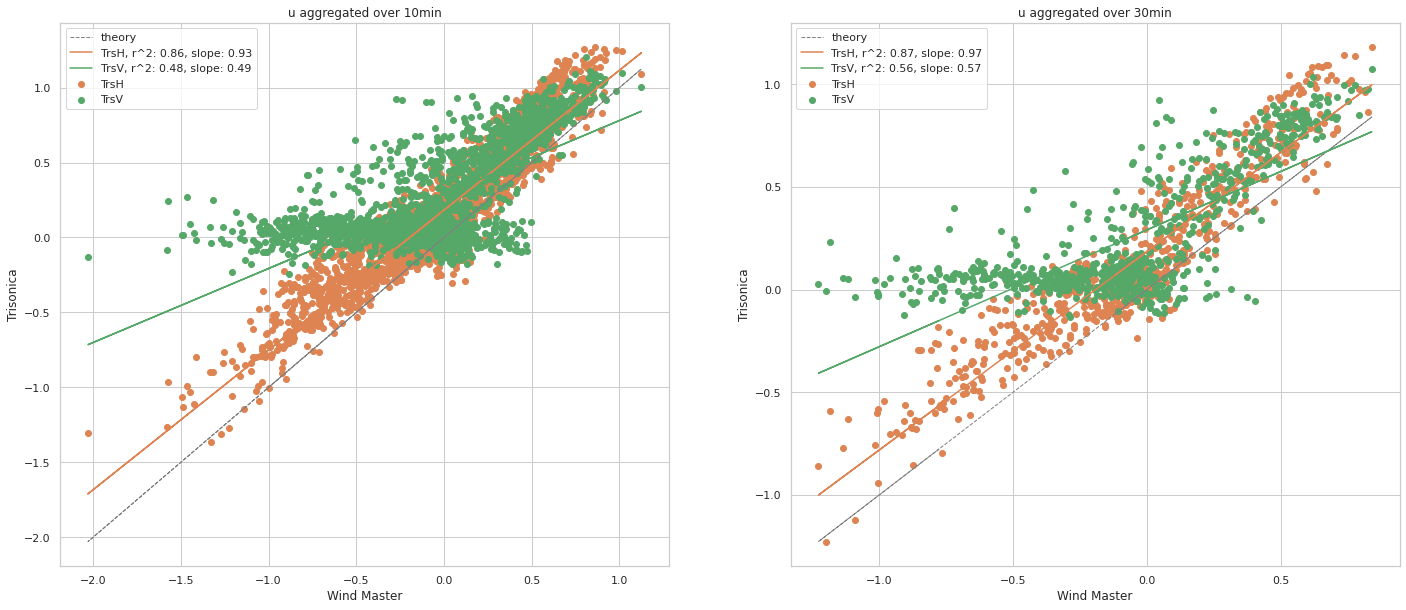

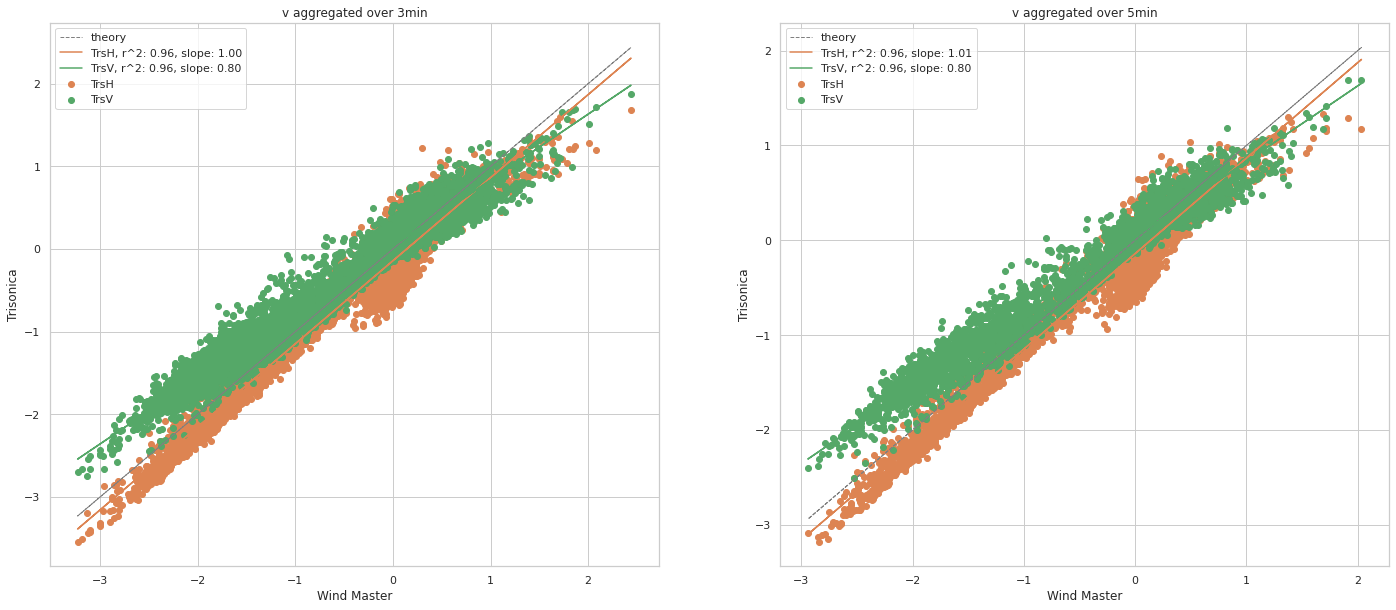

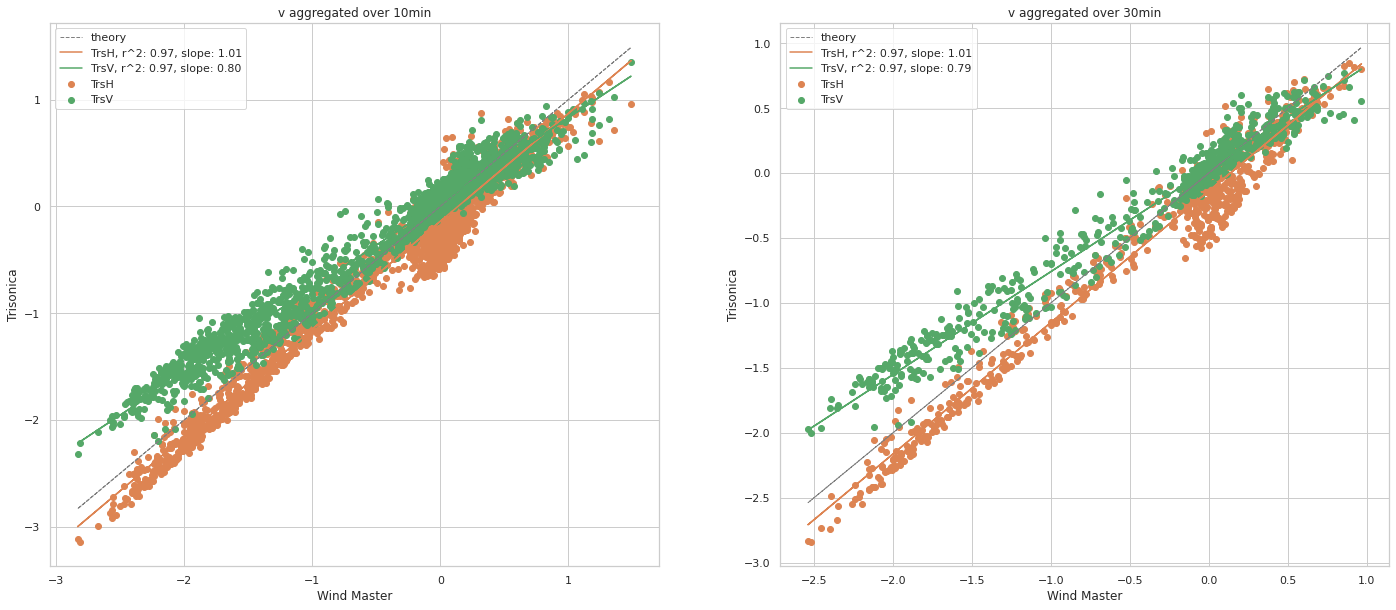

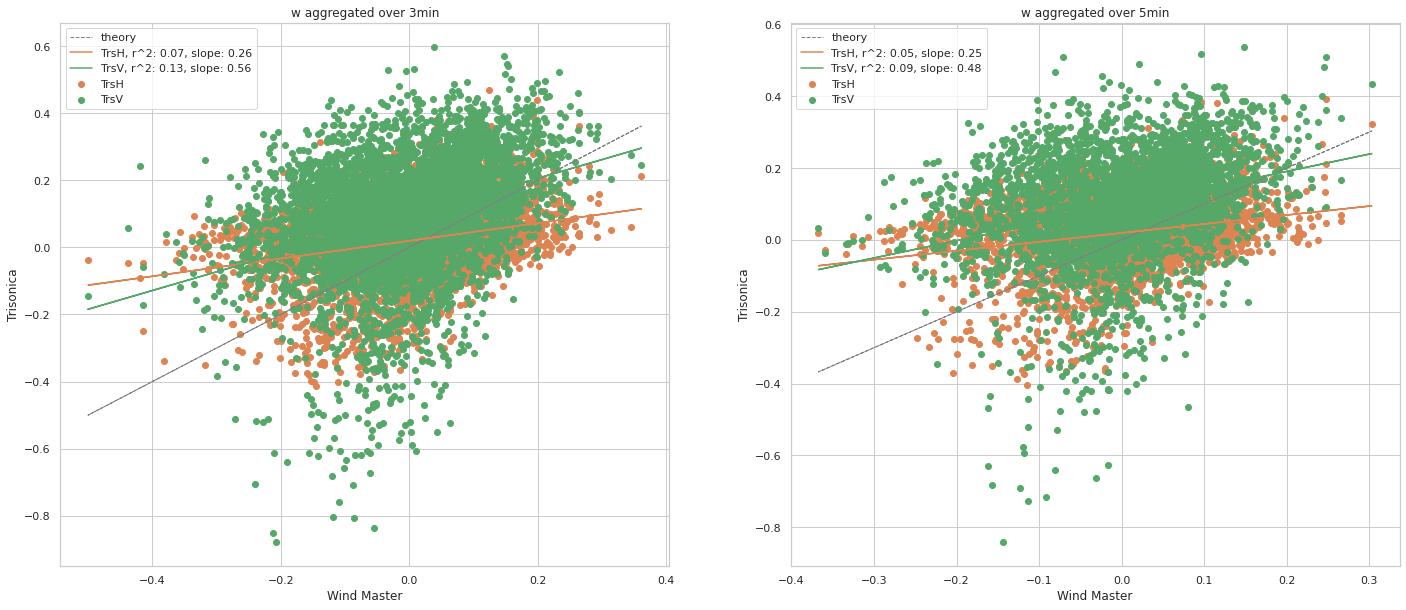

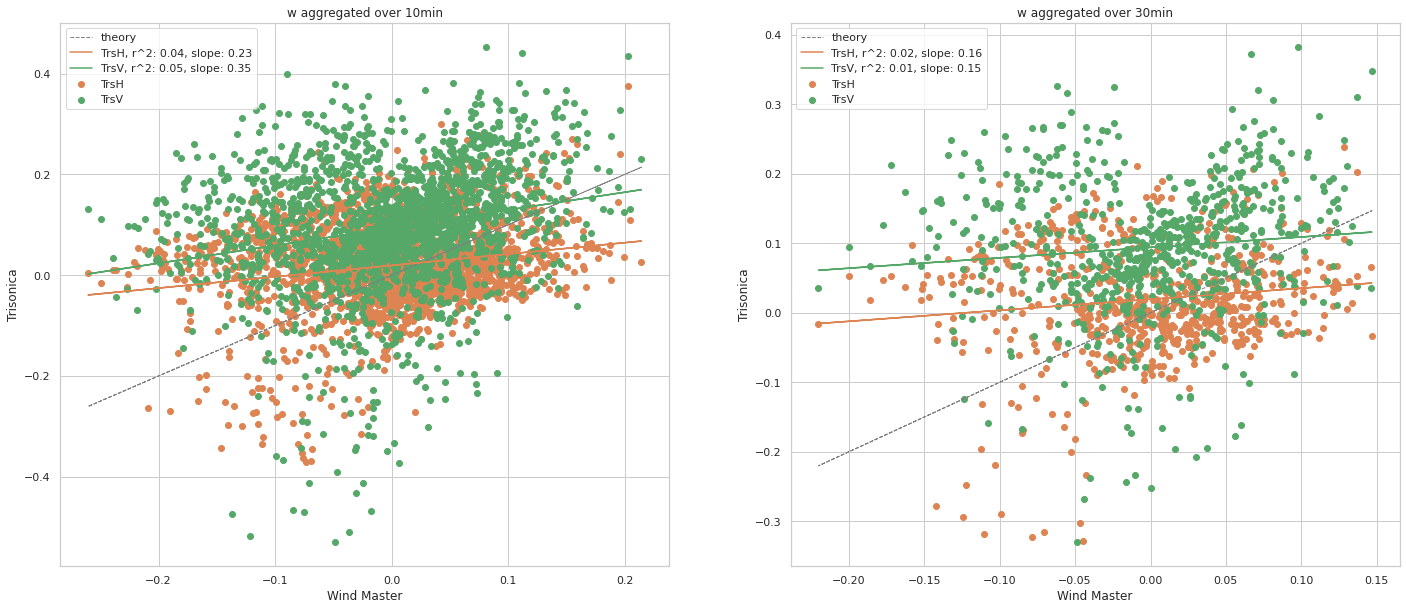

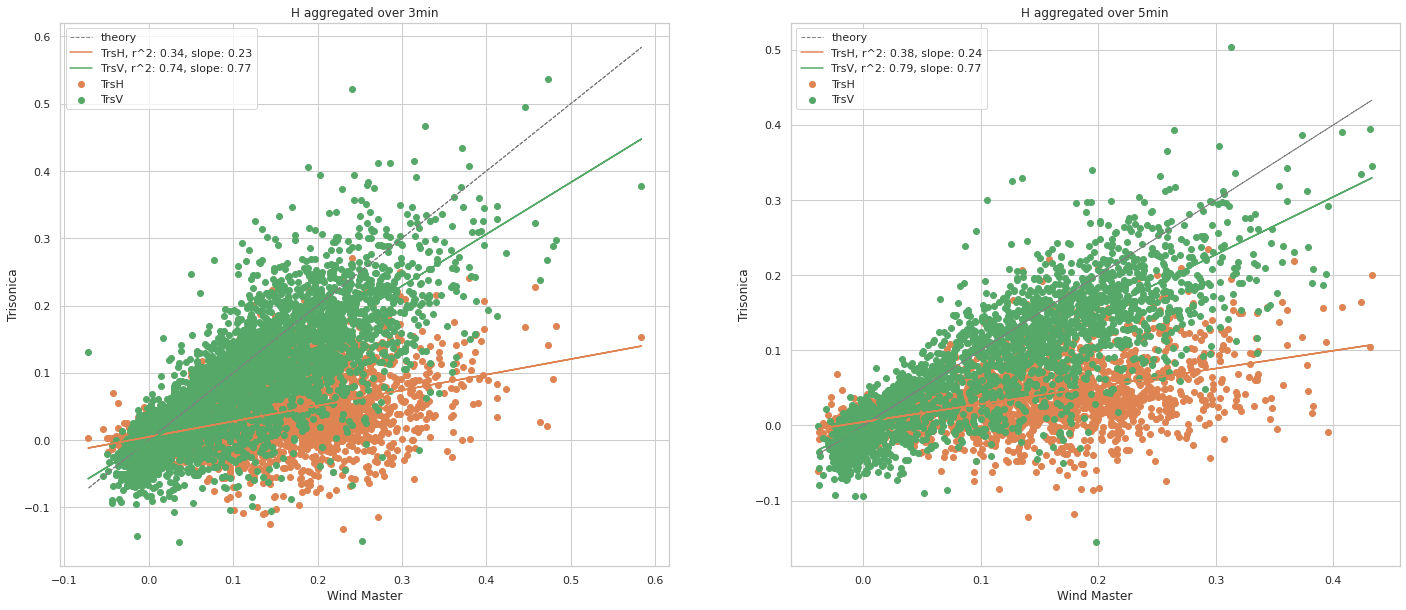

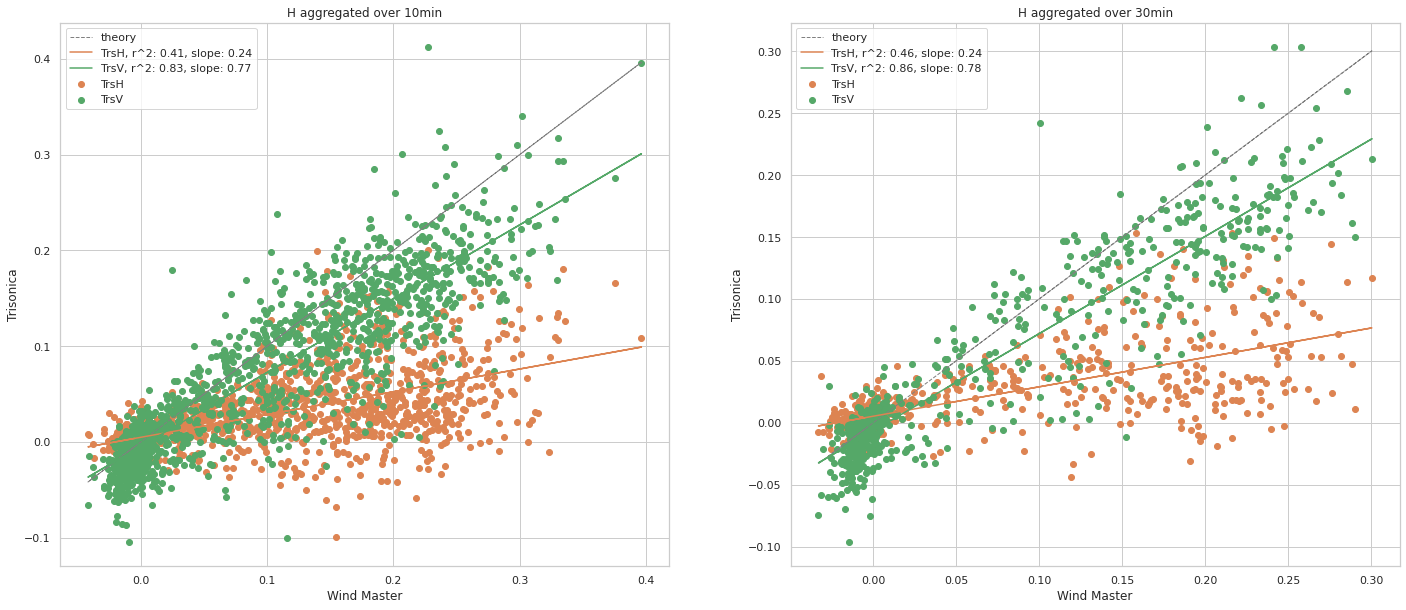

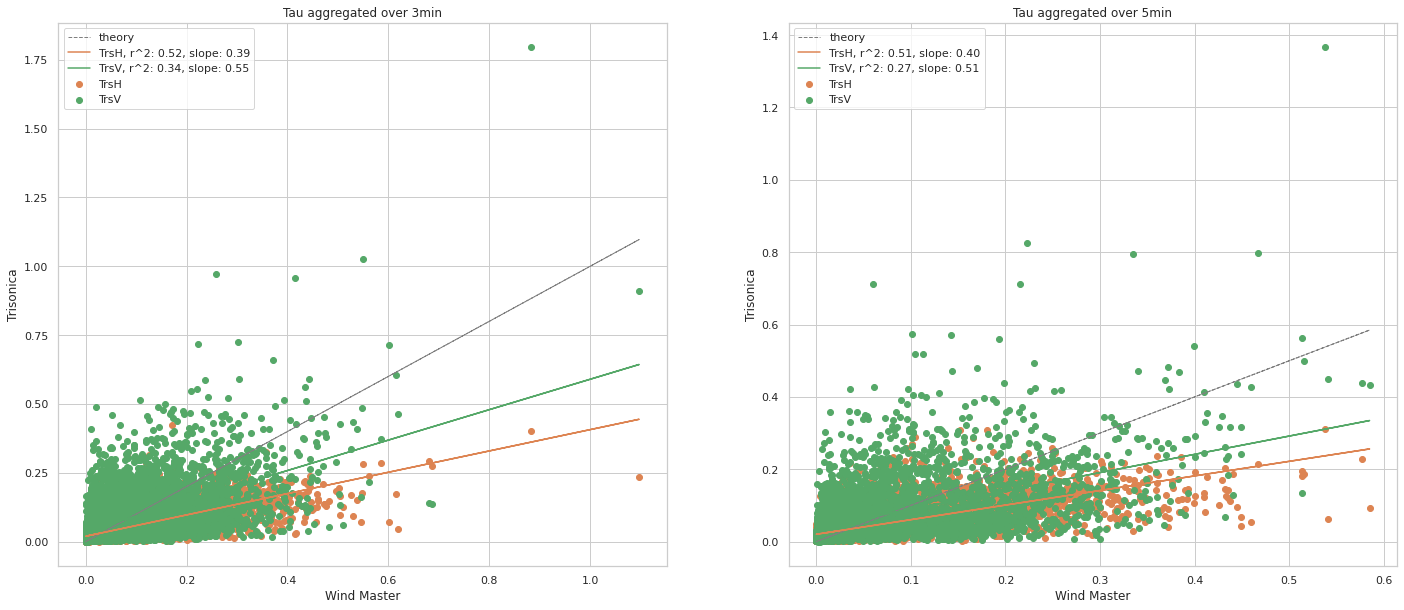

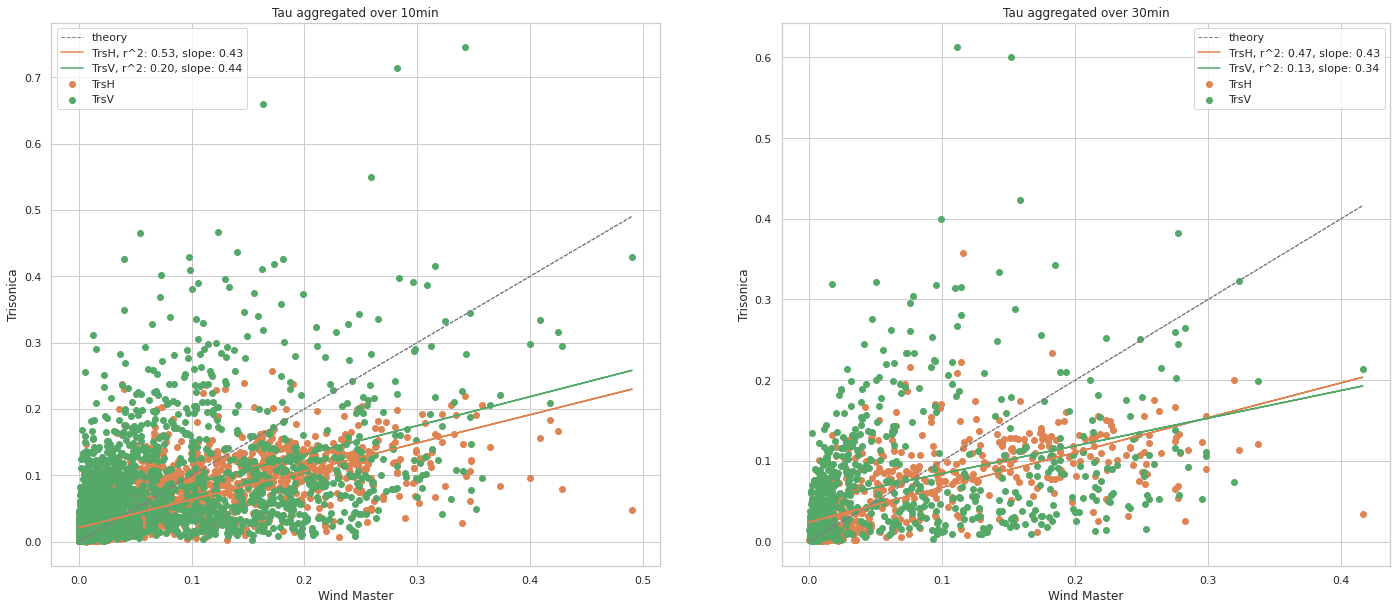

In [ ]:
matplotlib.rcParams['figure.figsize'] = (24,10)
for (col, time), ax_idx in zip( product(['wind_speed', 'wind_speed_hor', 'u', 'v', 'w', 'H', 'Tau' ], ['3min', '5min', '10min', '30min']), cycle([0,1])):
    if ax_idx==0: axes = get_ax(1,2)
    plot_one_scatter(aggr_data[time], col, plot_info_all, title=f"aggregated over {time}", ax=axes[ax_idx])

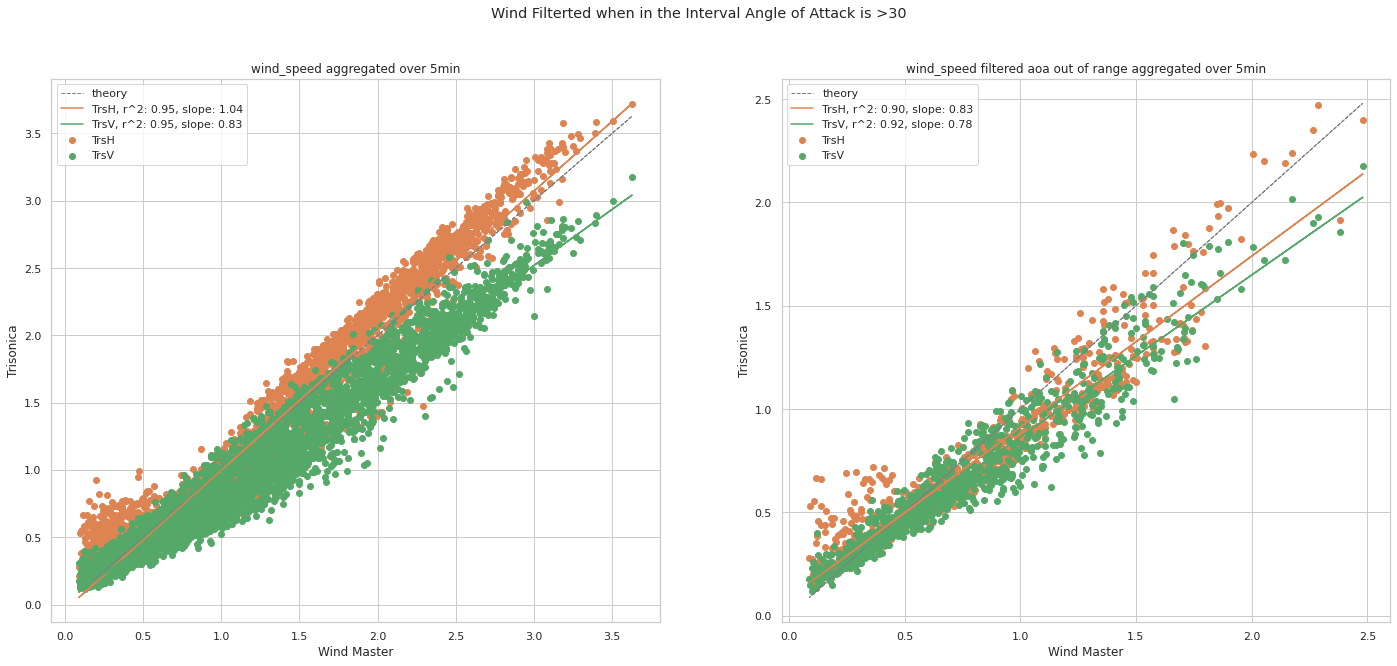

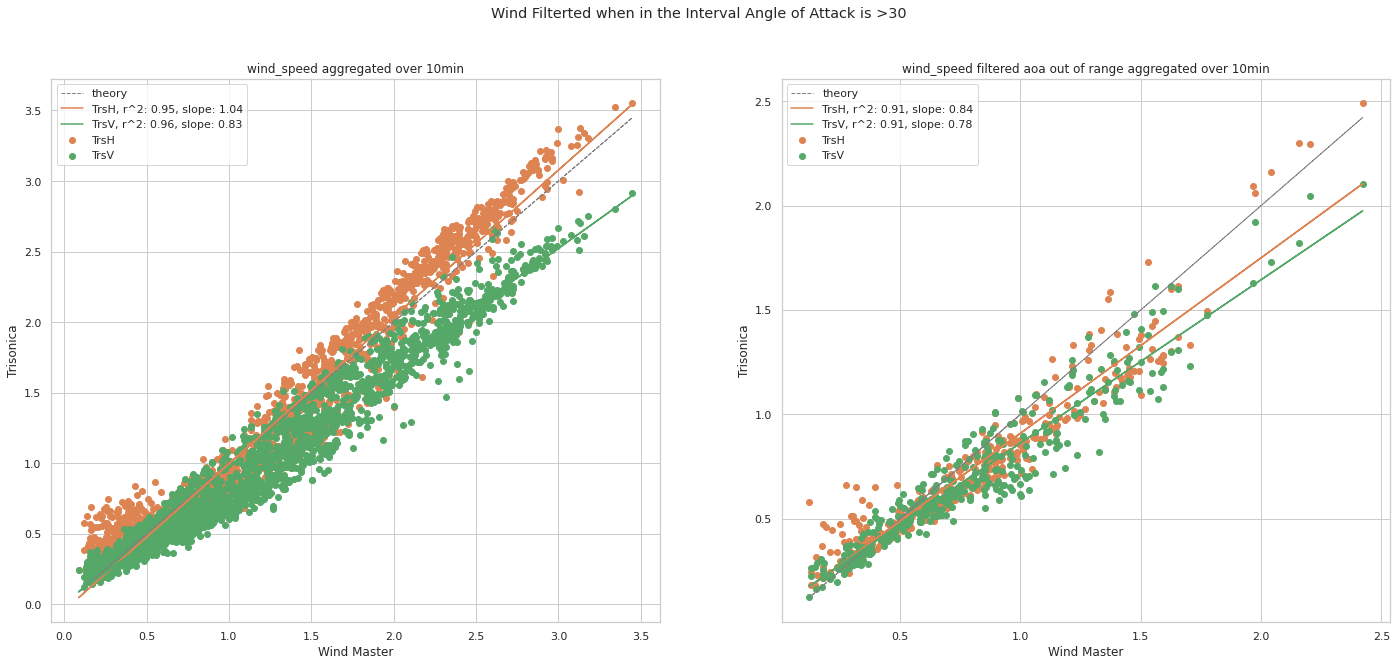

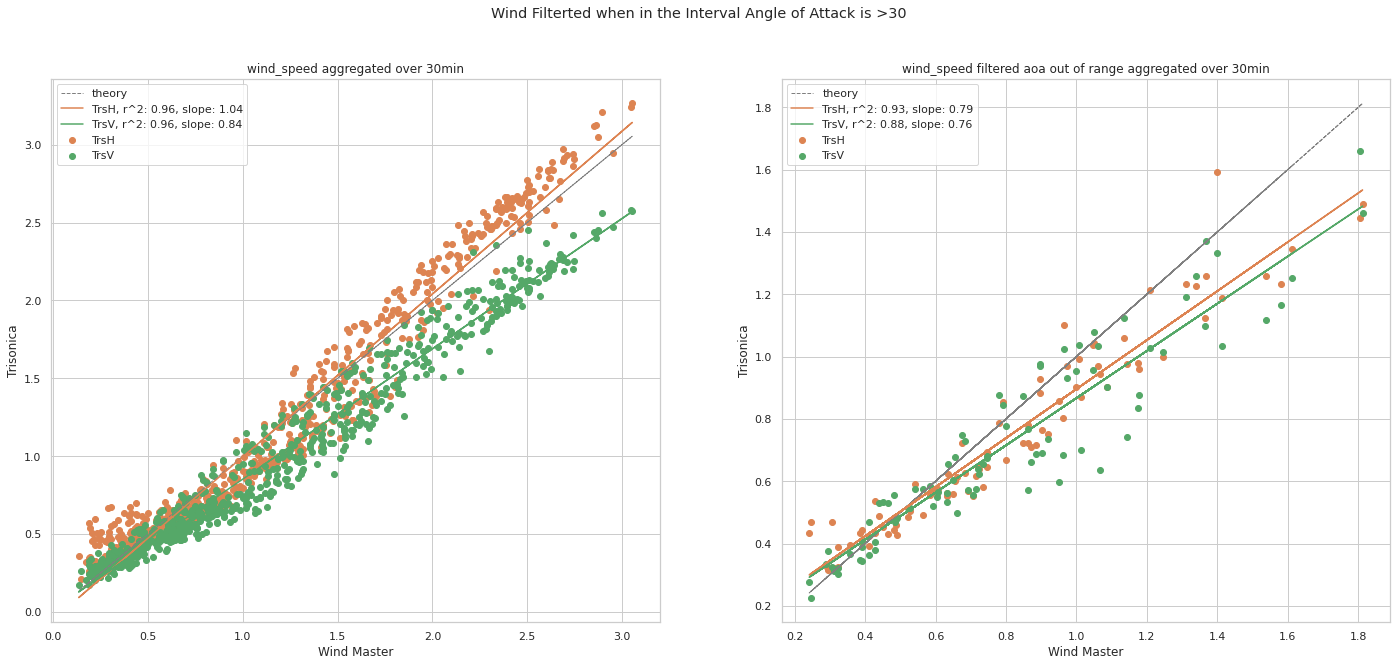

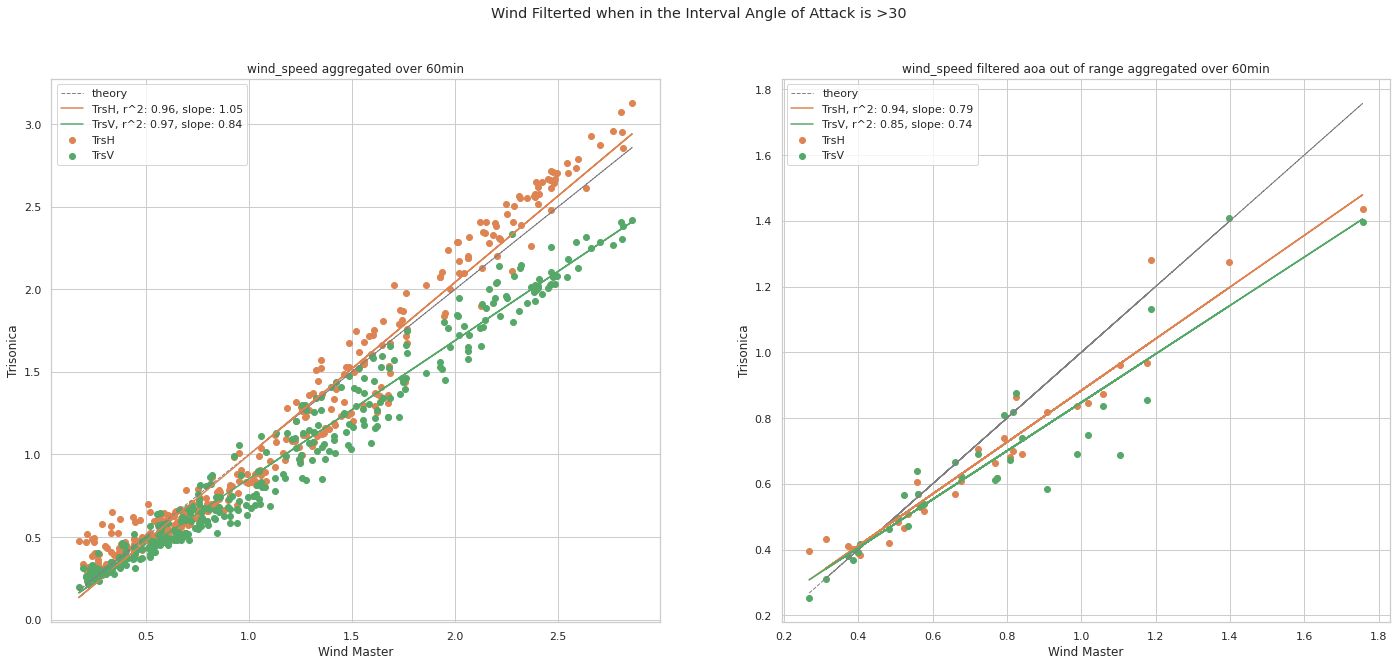

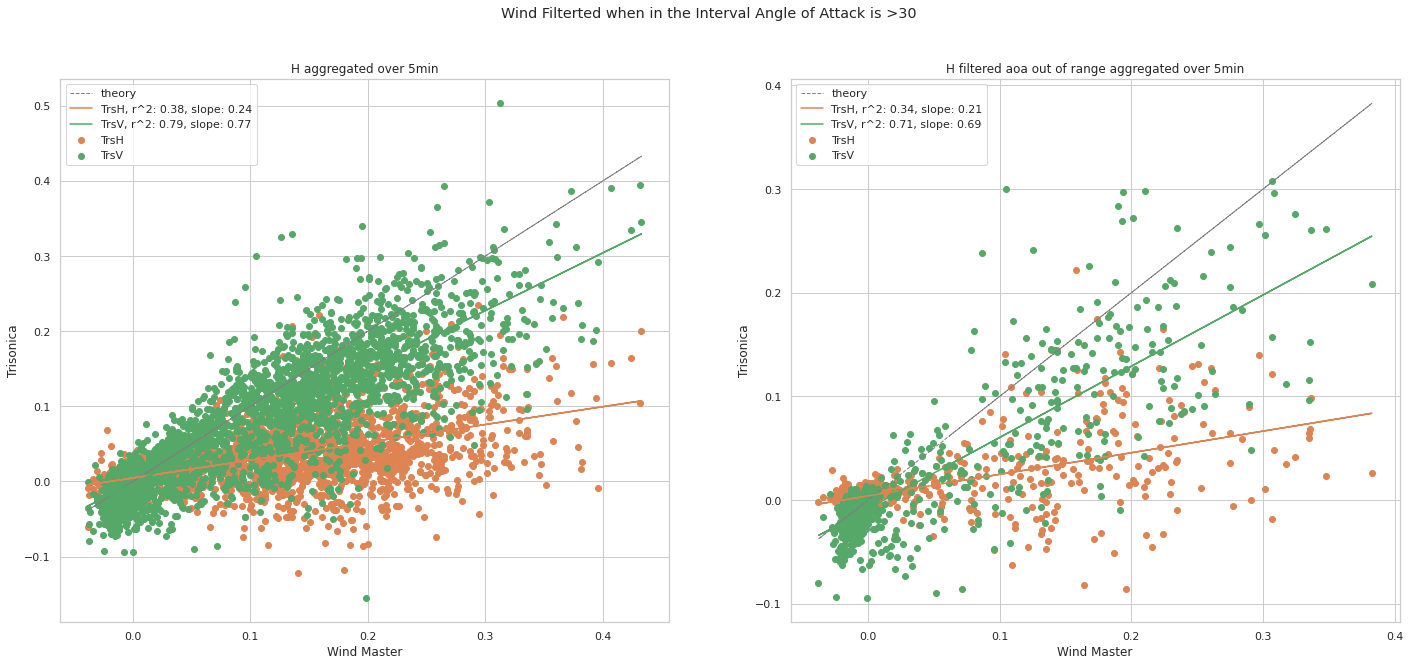

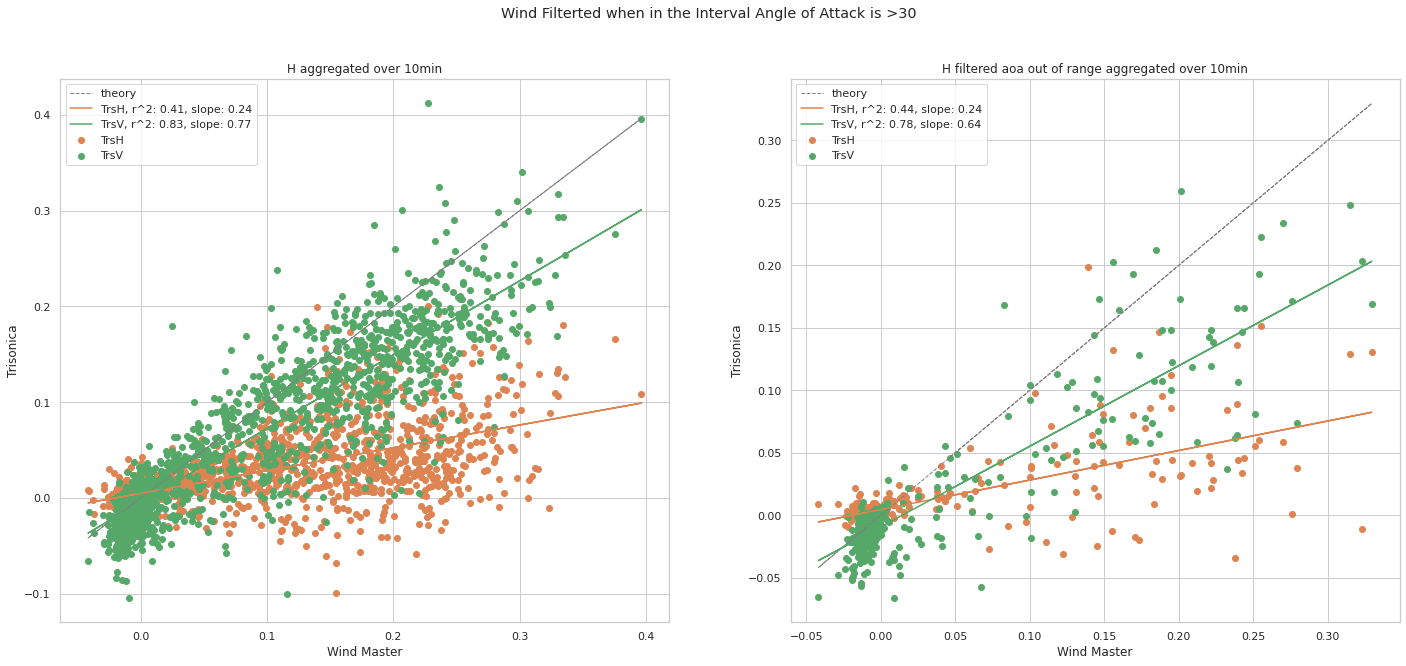

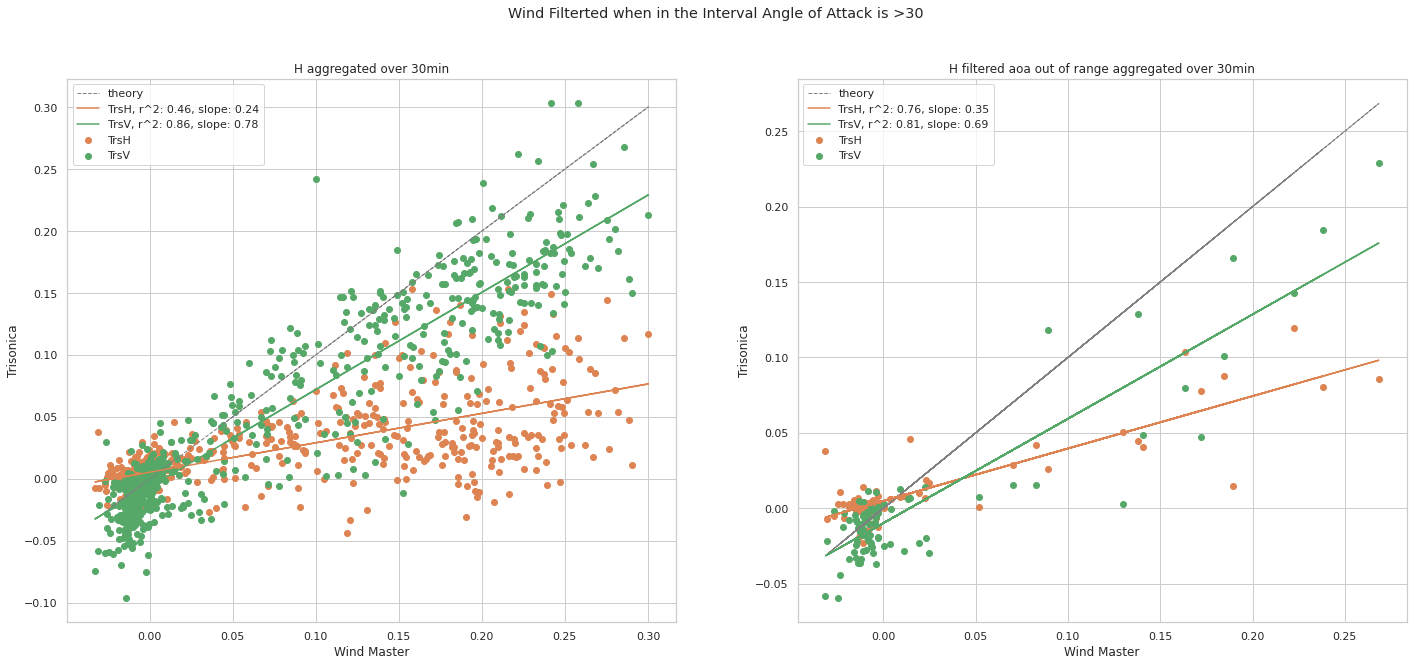

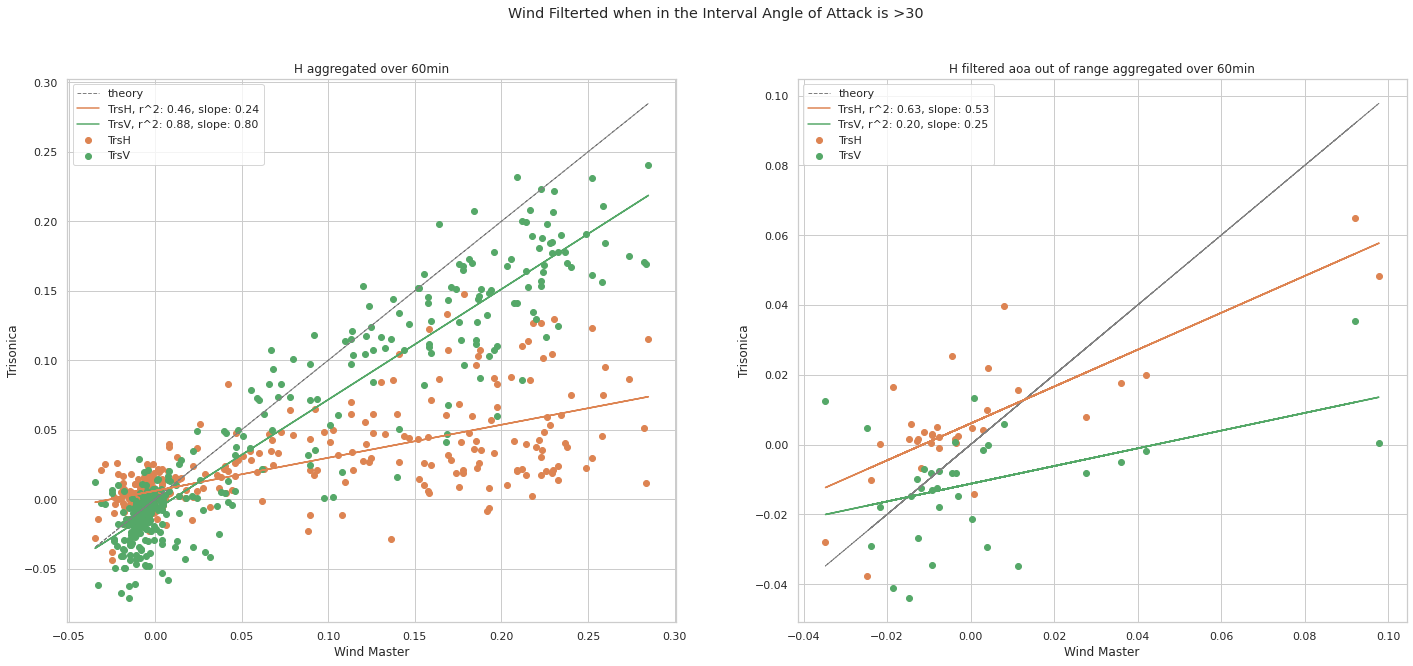

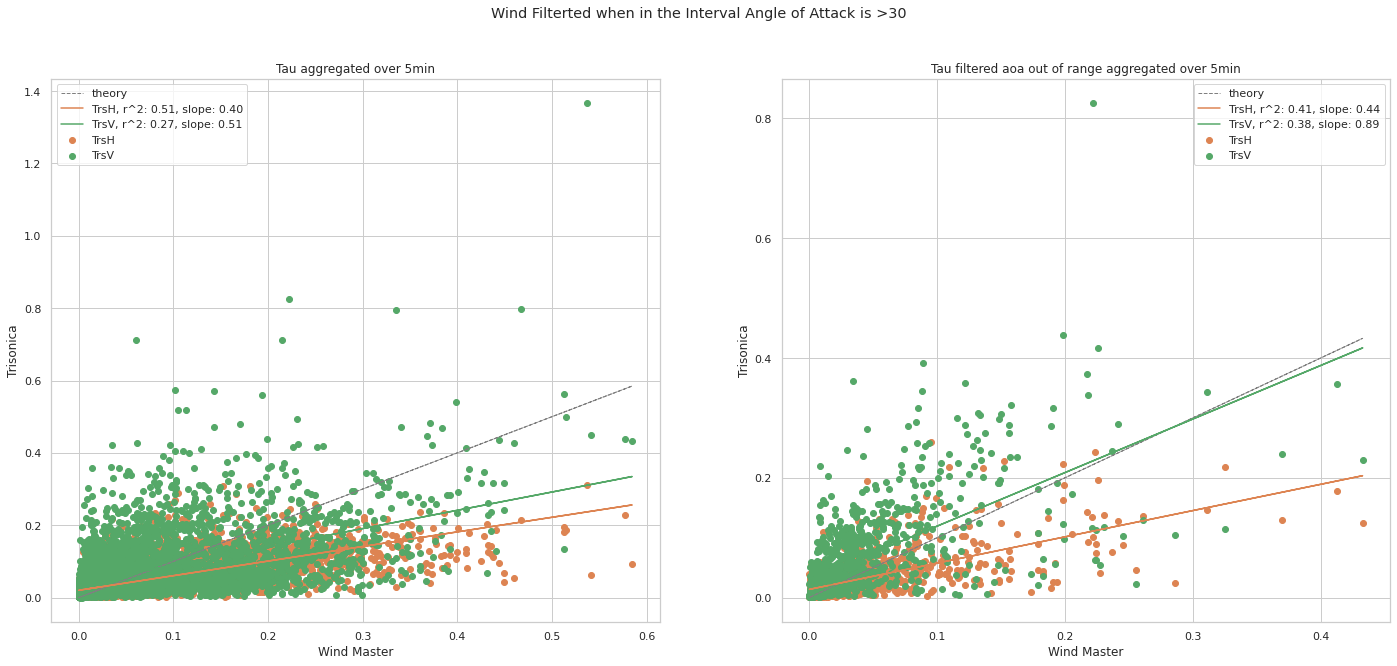

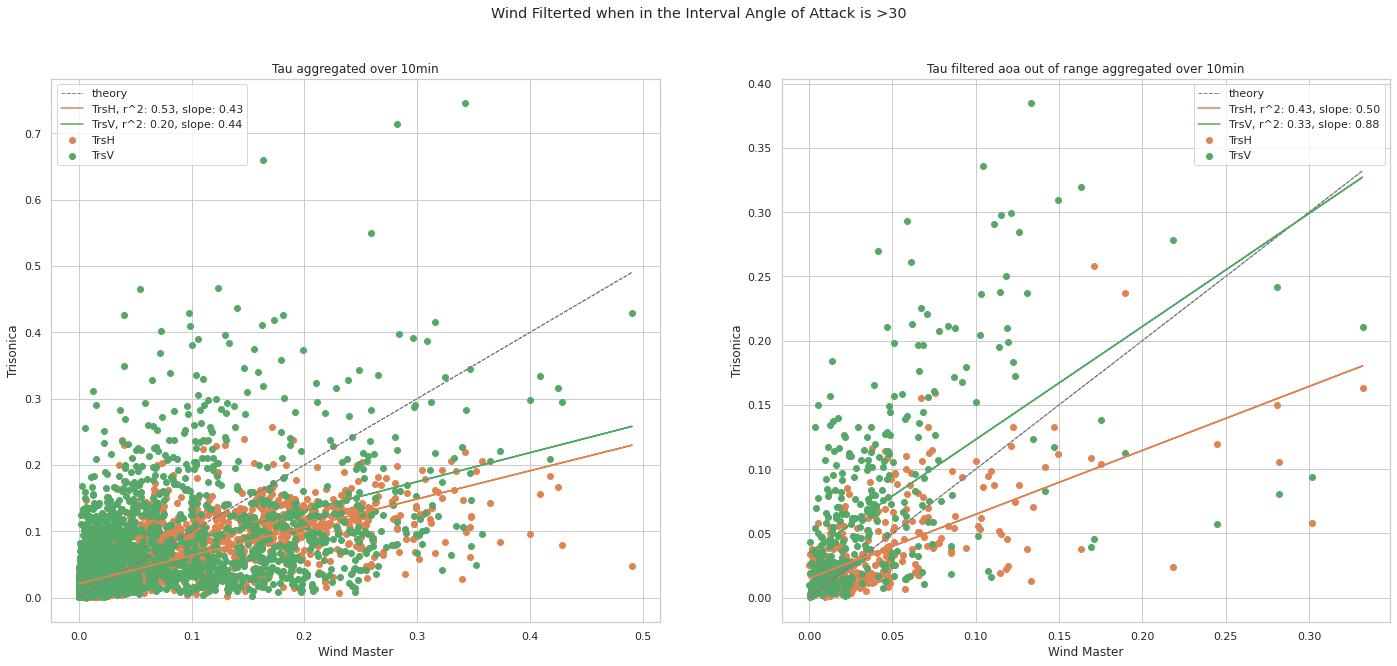

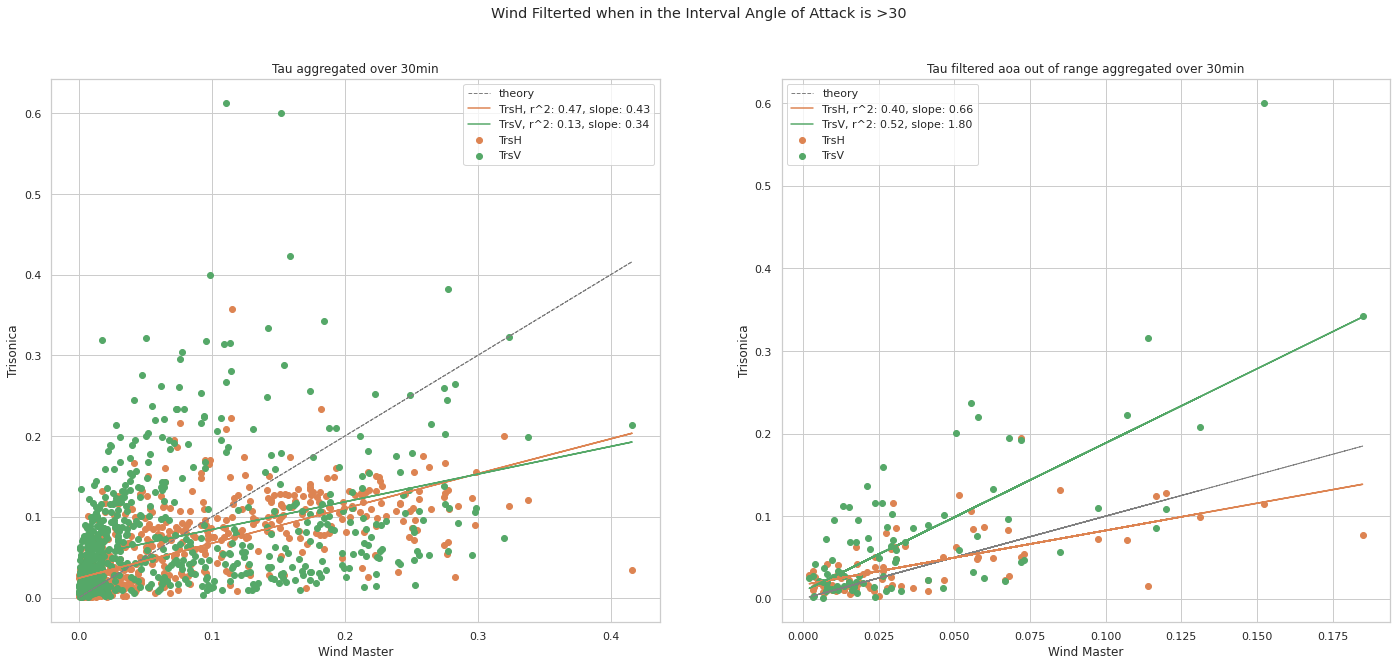

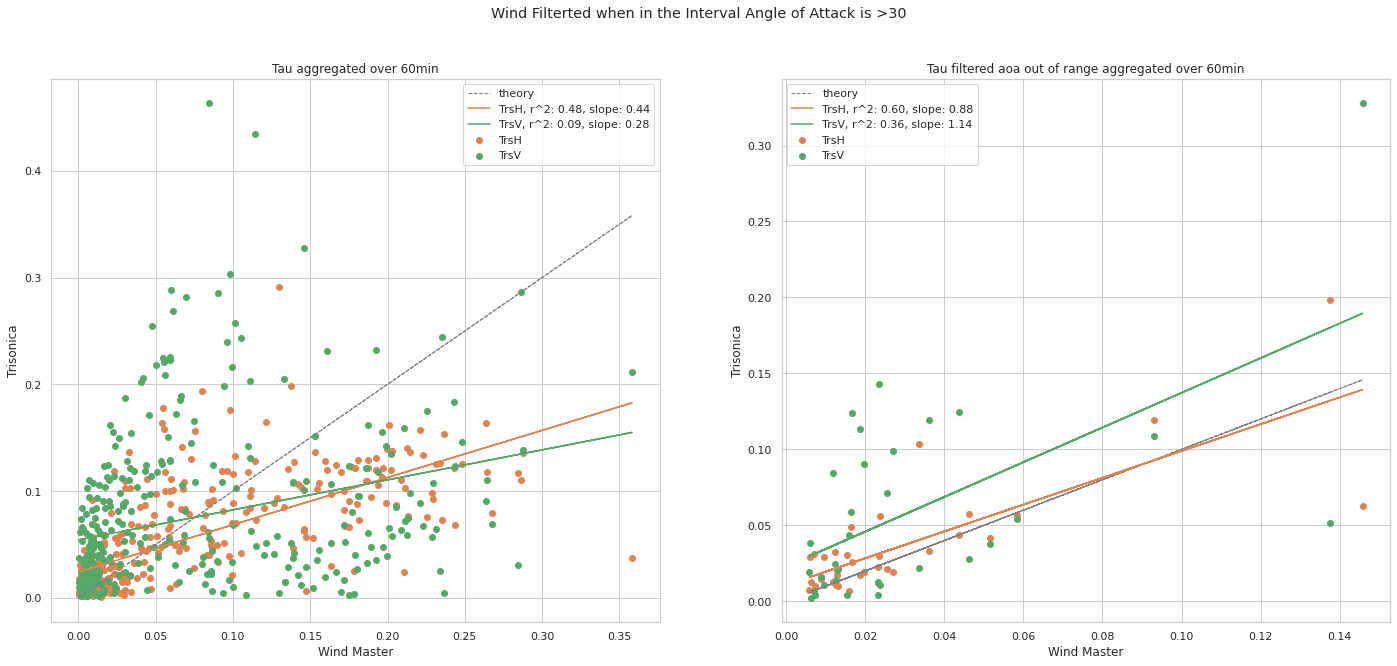

In [ ]:
matplotlib.rcParams['figure.figsize'] = (24,10)
for col, time in product(['wind_speed', 'H', 'Tau' ], ['5min', '10min', '30min']):
    axes = get_ax(1,2)
    plot_one_scatter(aggr_data[time], col, plot_info_all, title=f"aggregated over {time}", ax=axes[0])
    plot_one_scatter([df[not_good_aoa[time]] for df in aggr_data[time]], col, plot_info_all, title=f"filtered aoa out of range aggregated over {time}", ax=axes[1])
    plt.suptitle("Wind Filterted when in the Interval Angle of Attack is >30")

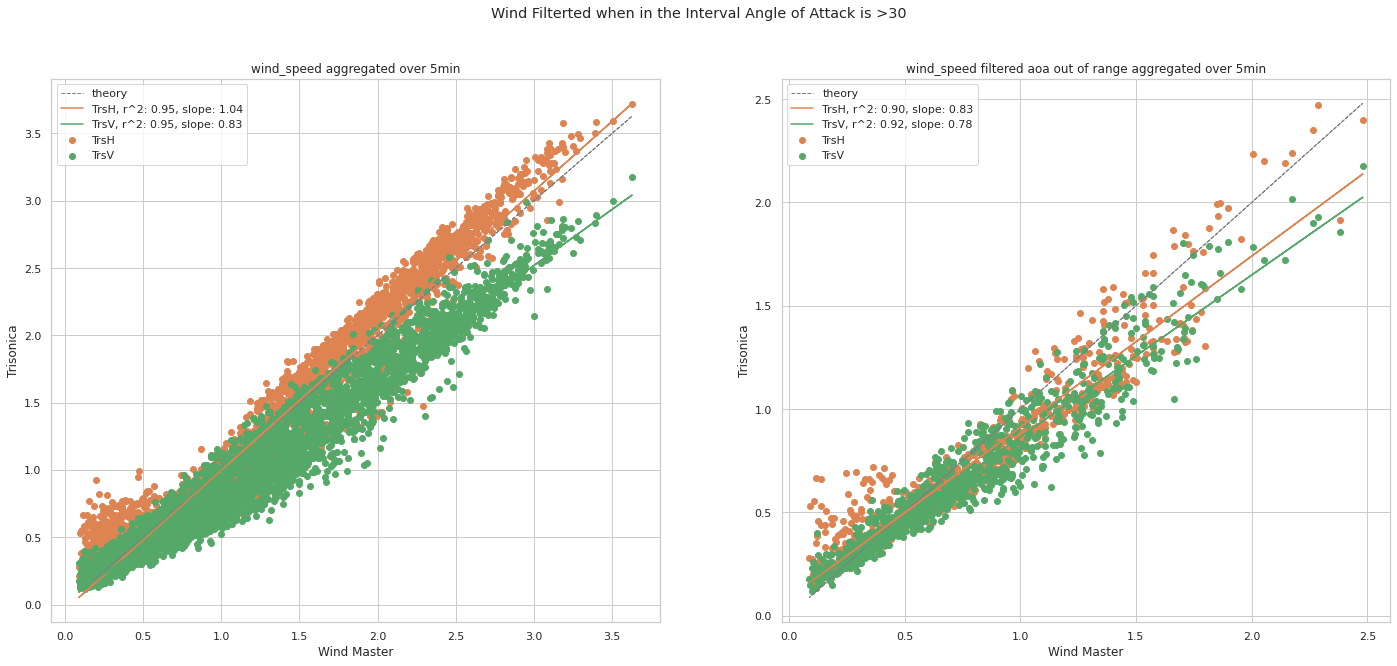

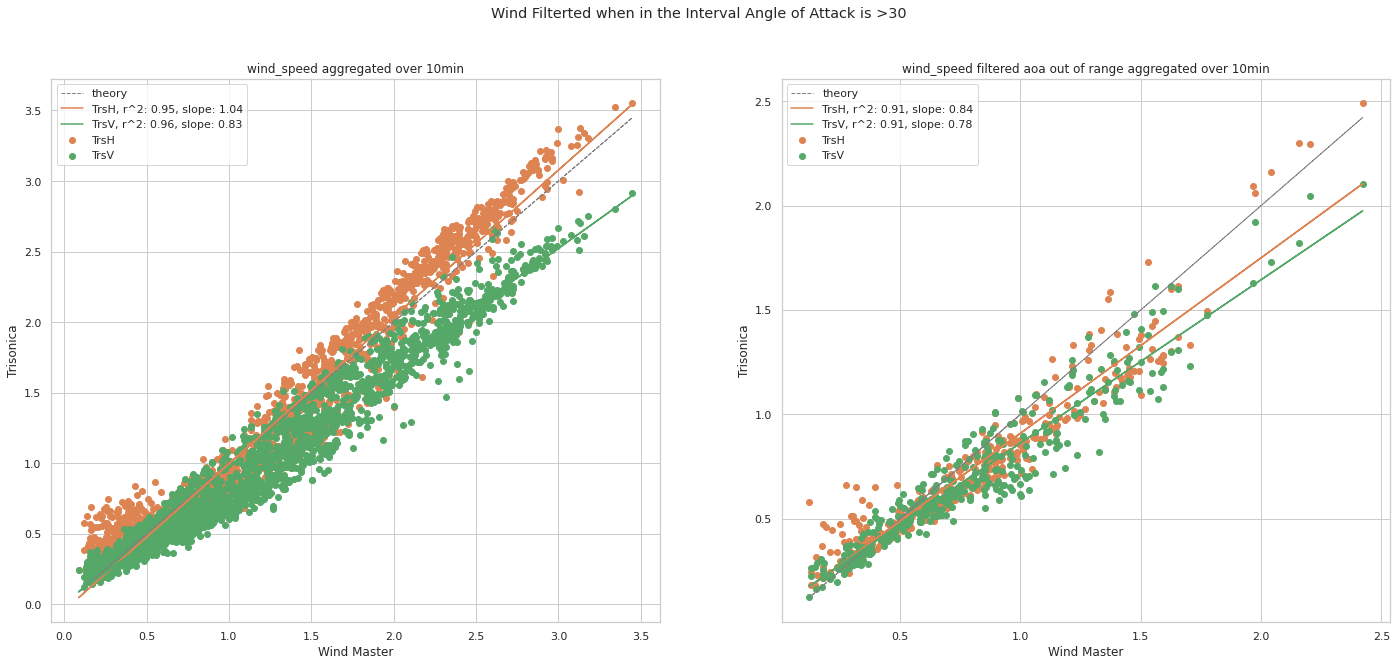

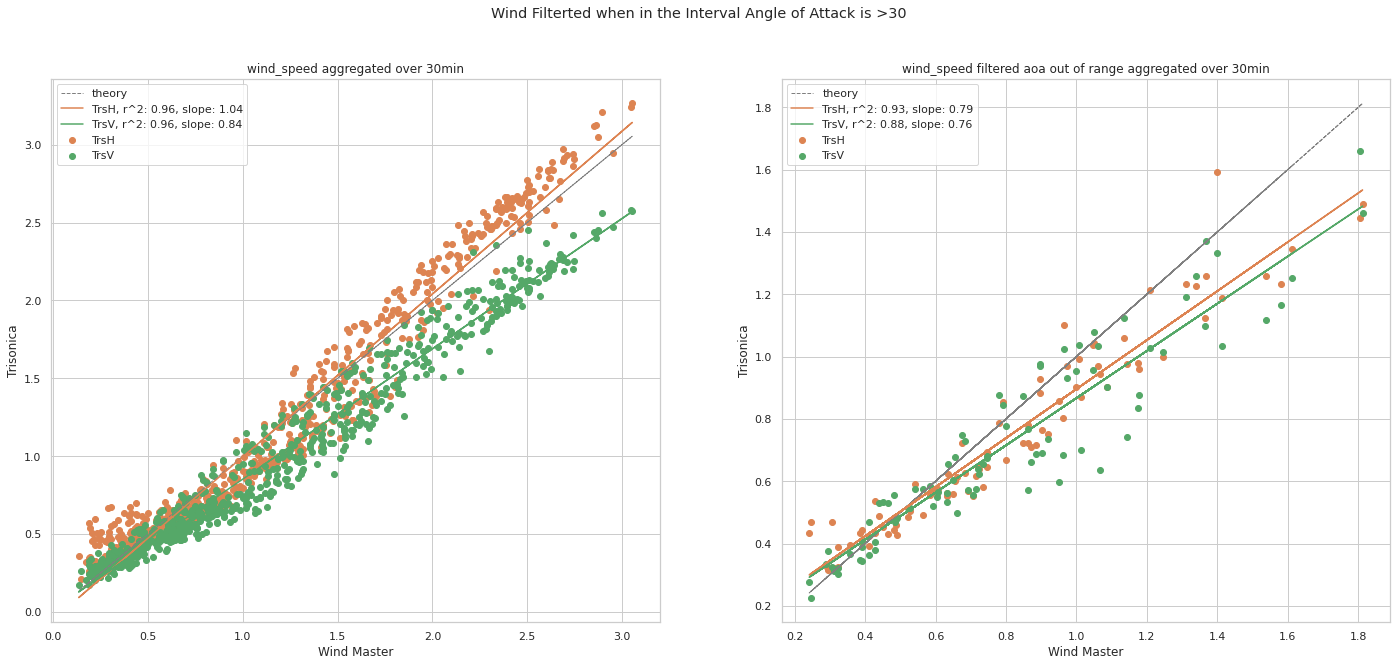

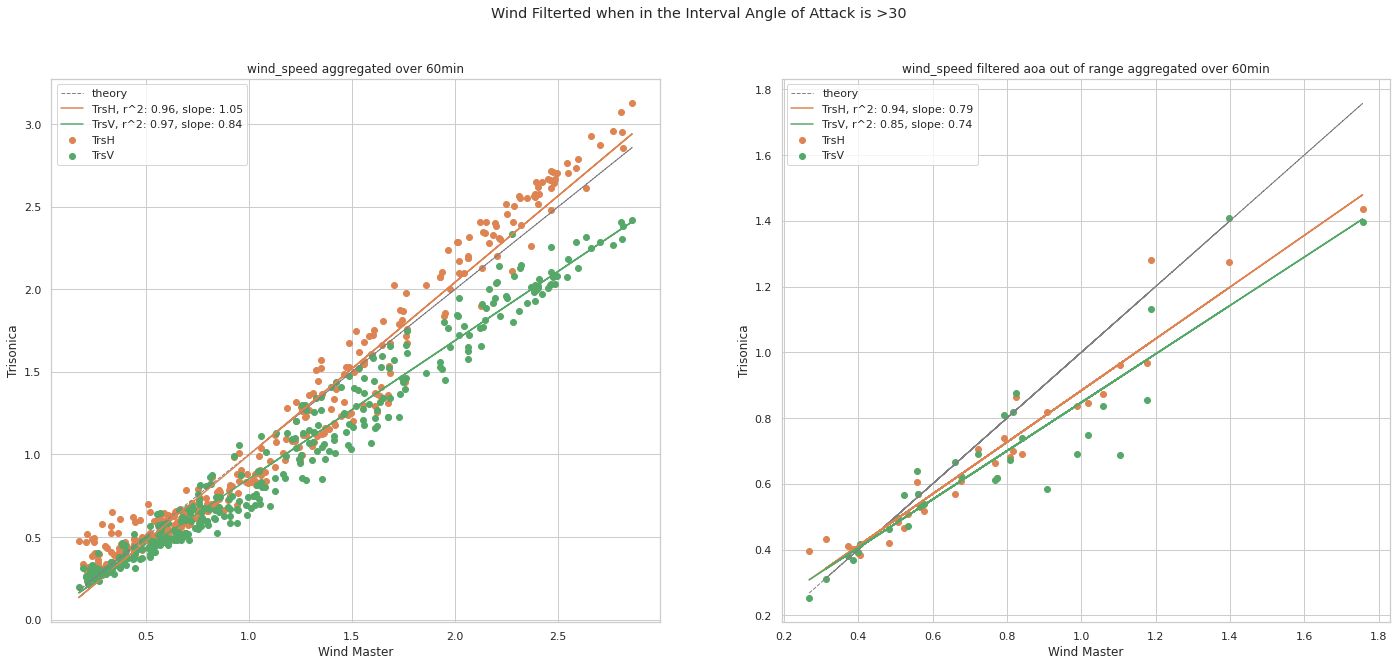

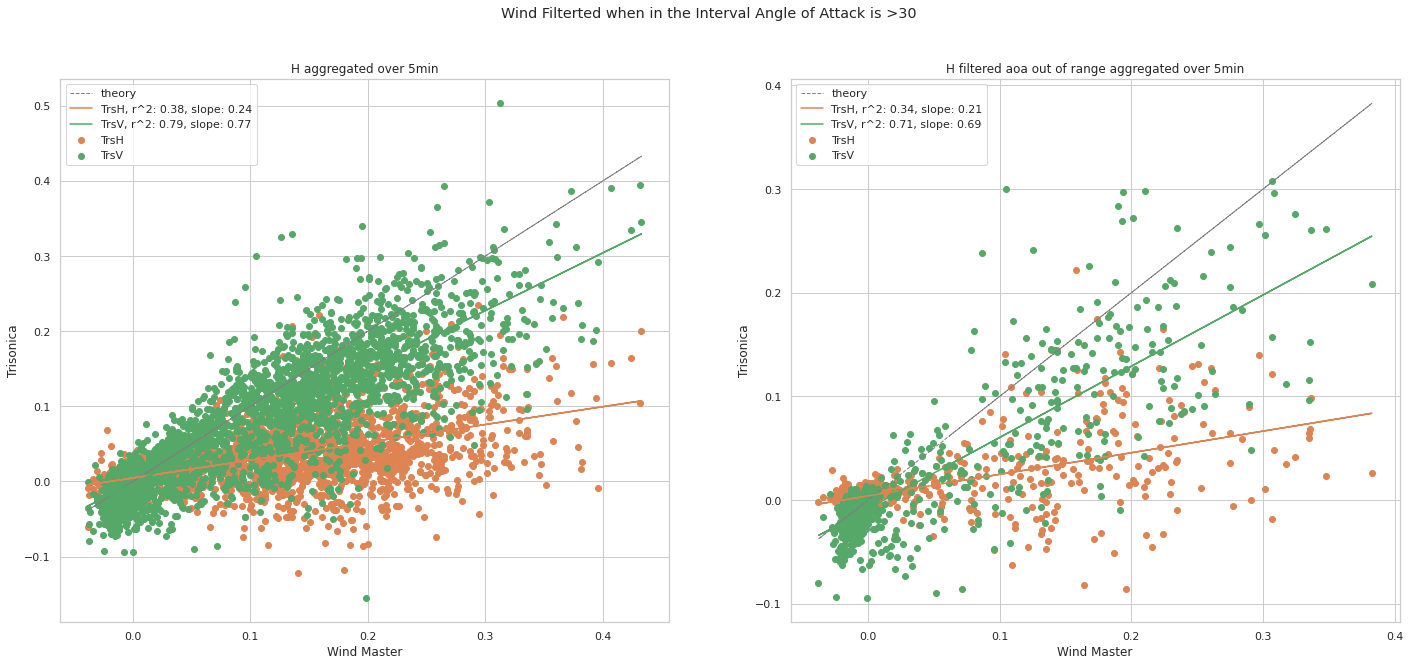

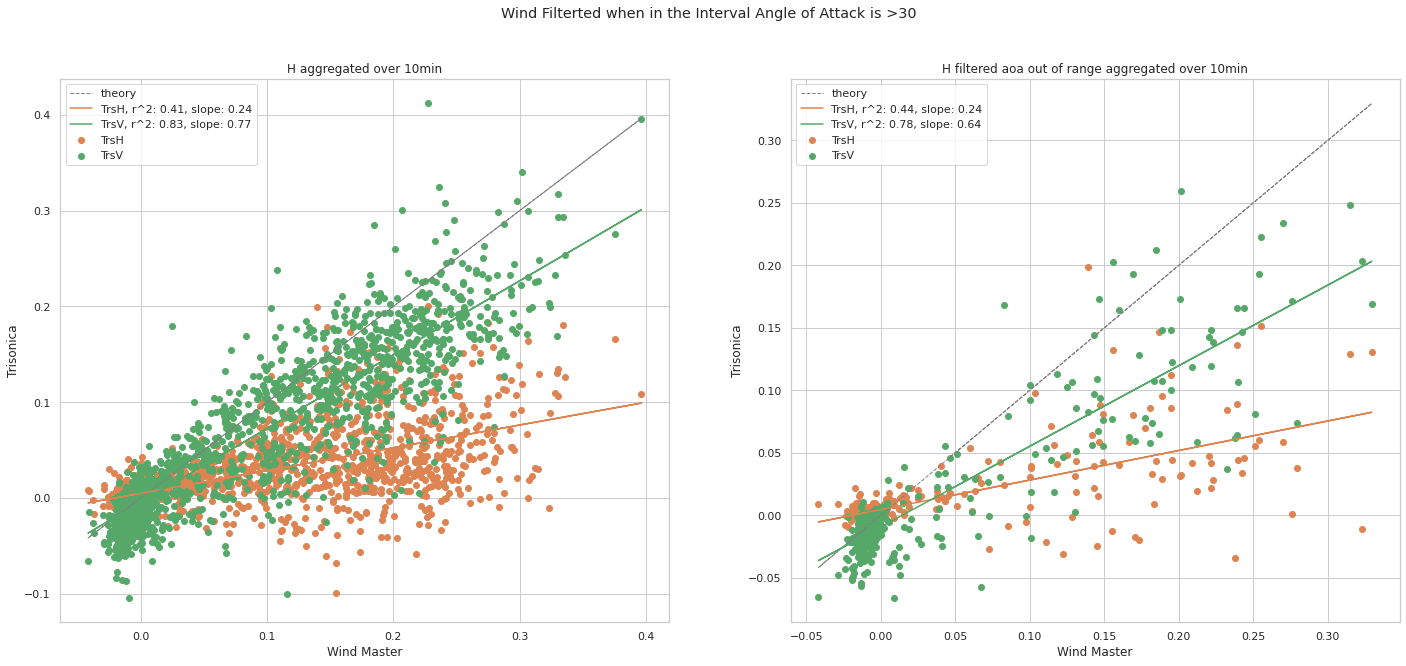

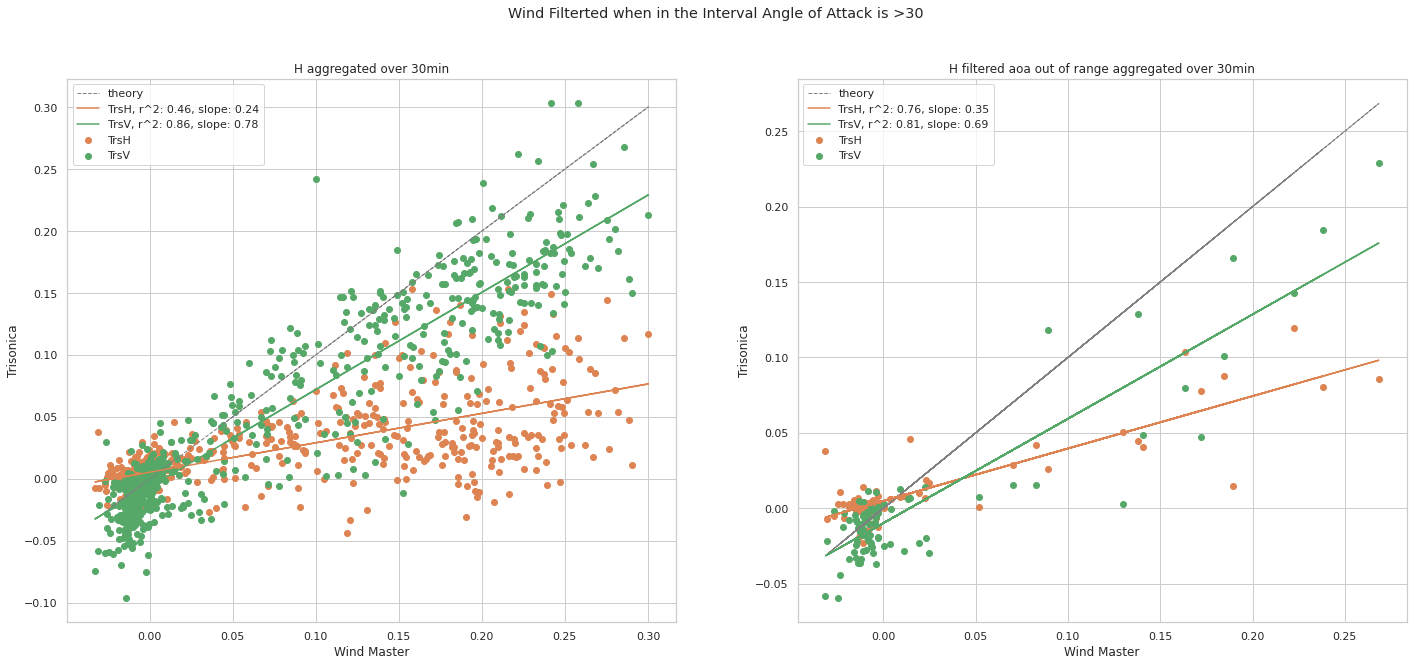

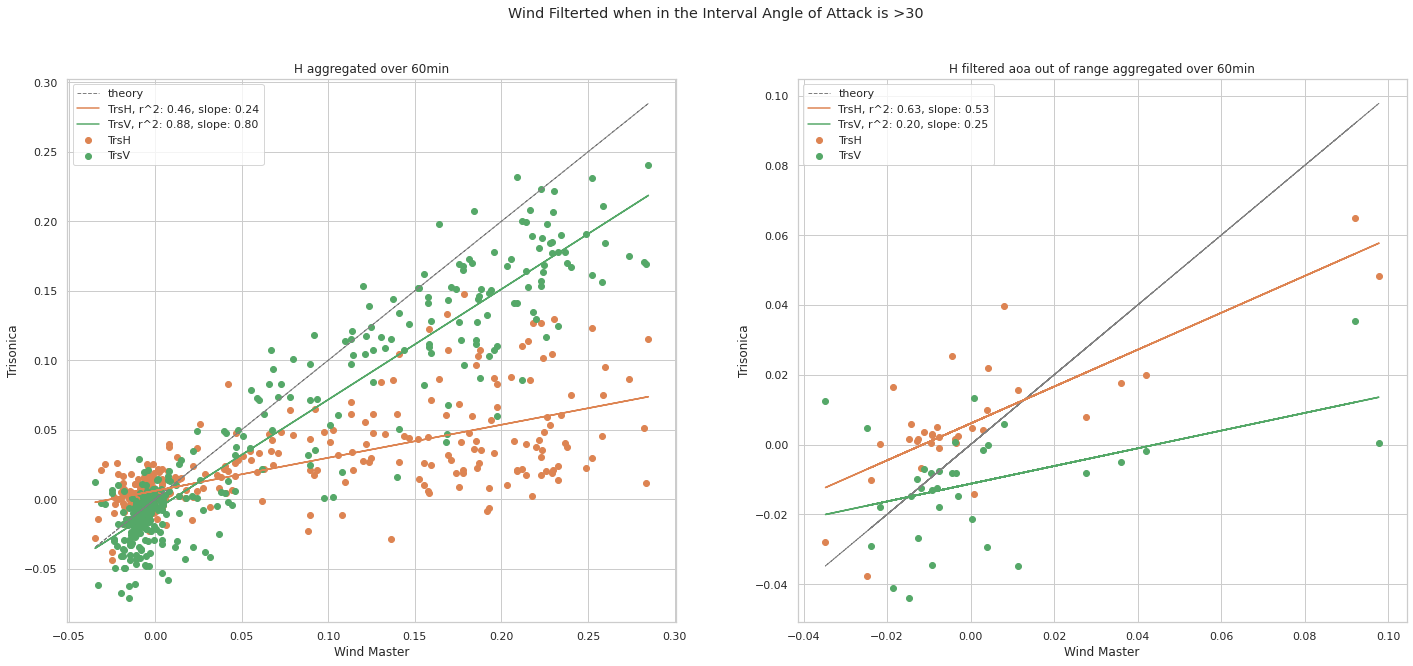

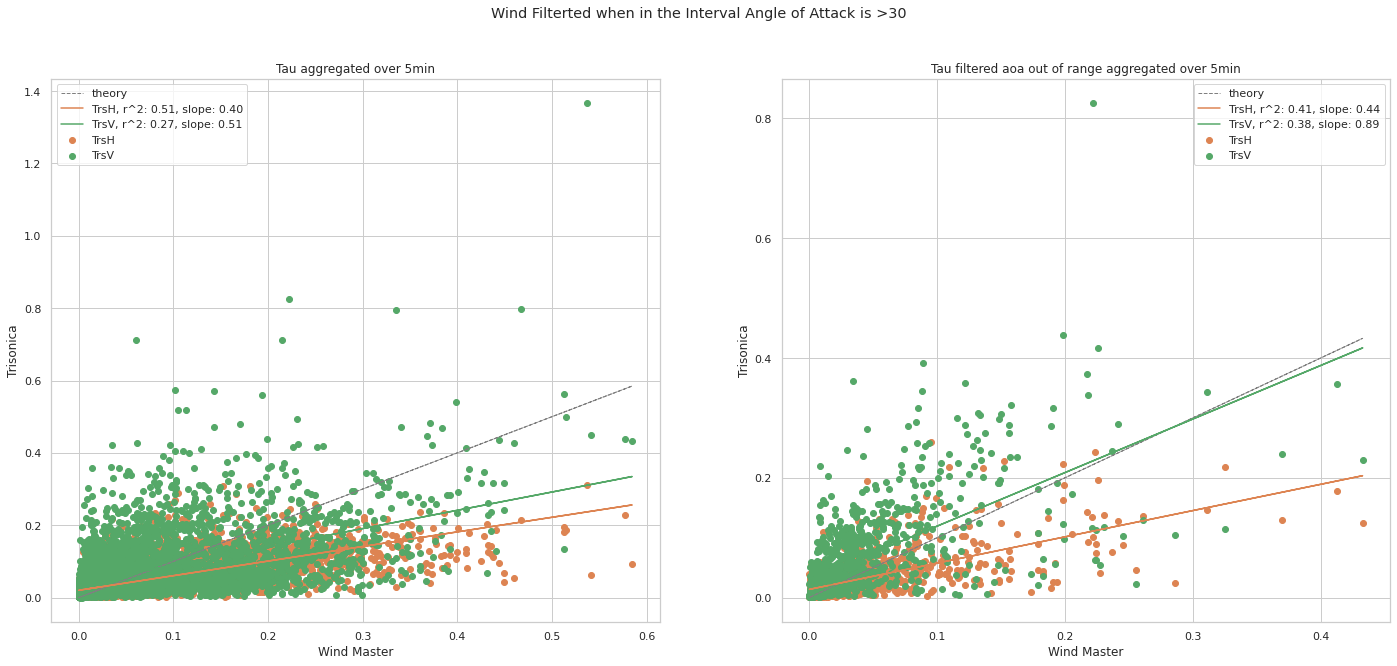

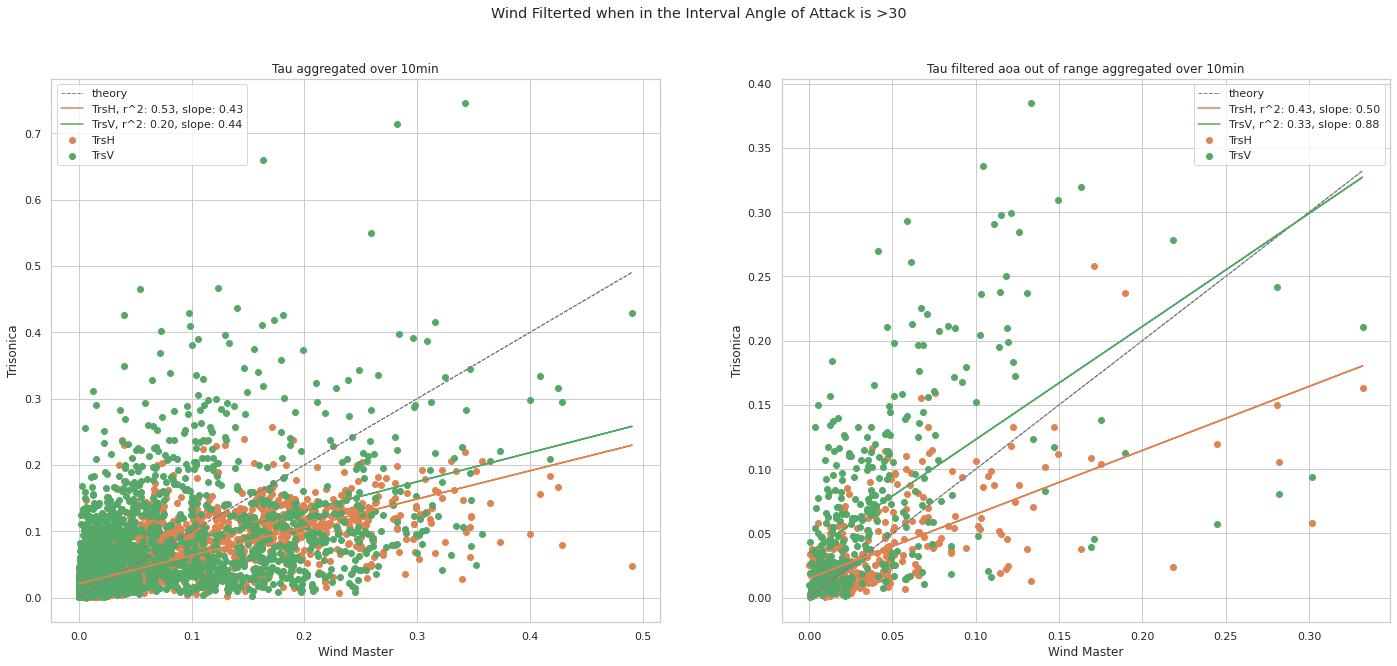

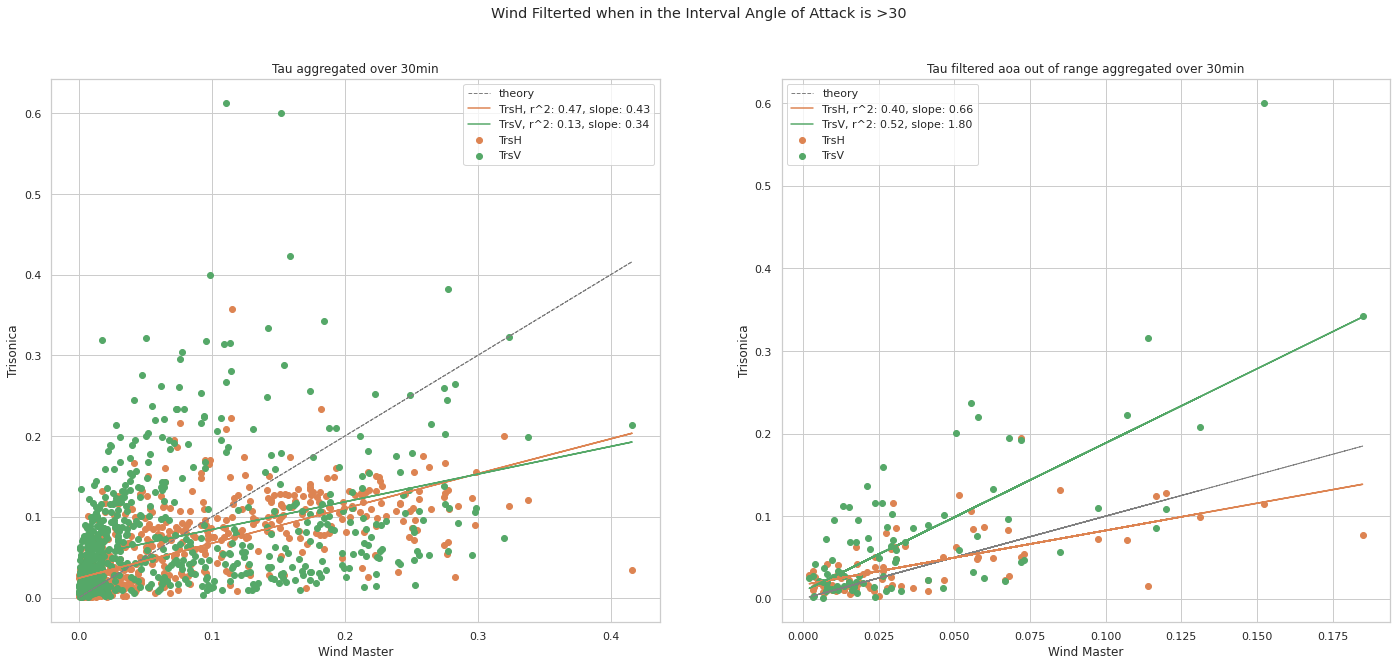

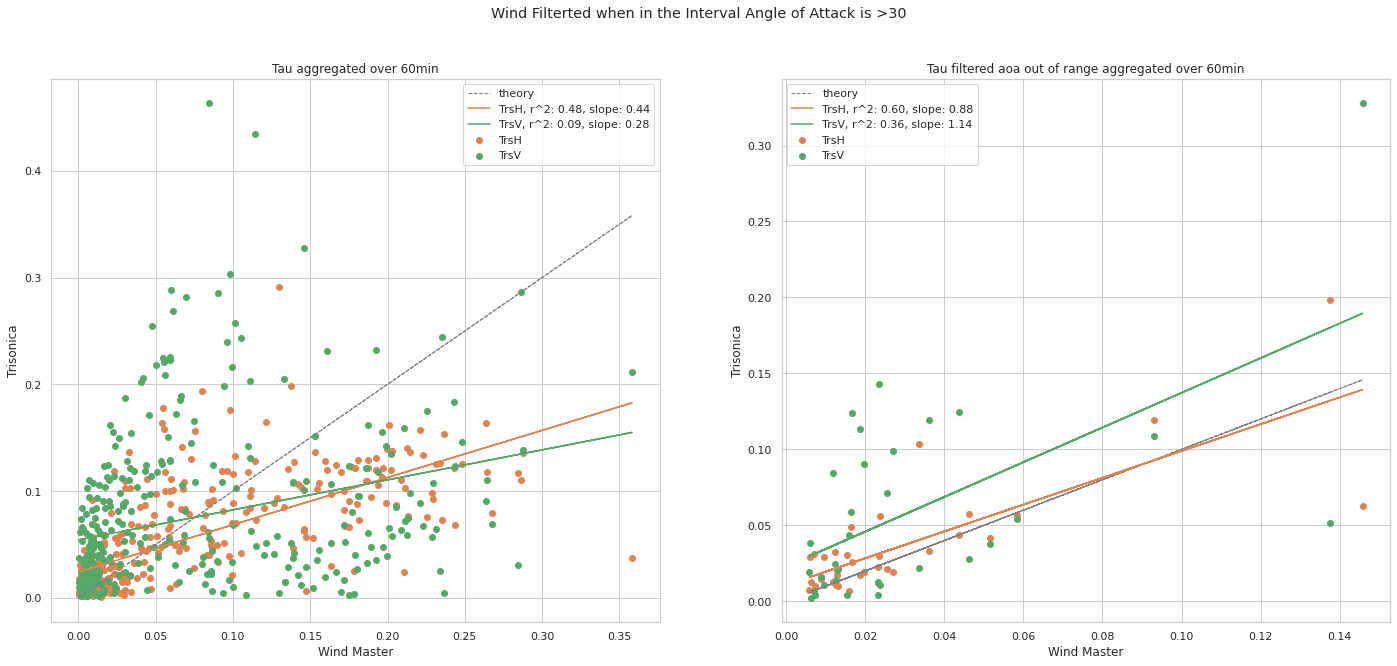

In [ ]:
matplotlib.rcParams['figure.figsize'] = (24,10)
for col, time in product(['wind_speed', 'H', 'Tau' ], ['5min', '10min', '30min']):
    axes = get_ax(1,2)
    plot_one_scatter(aggr_data[time], col, plot_info_all, title=f"aggregated over {time}", ax=axes[0])
    plot_one_scatter([df[not_good_aoa[time]] for df in aggr_data[time]], col, plot_info_all, title=f"filtered aoa out of range aggregated over {time}", ax=axes[1])
    plt.suptitle("Wind Filterted when in the Interval Angle of Attack is >30")

## Filter by Wind Dir

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


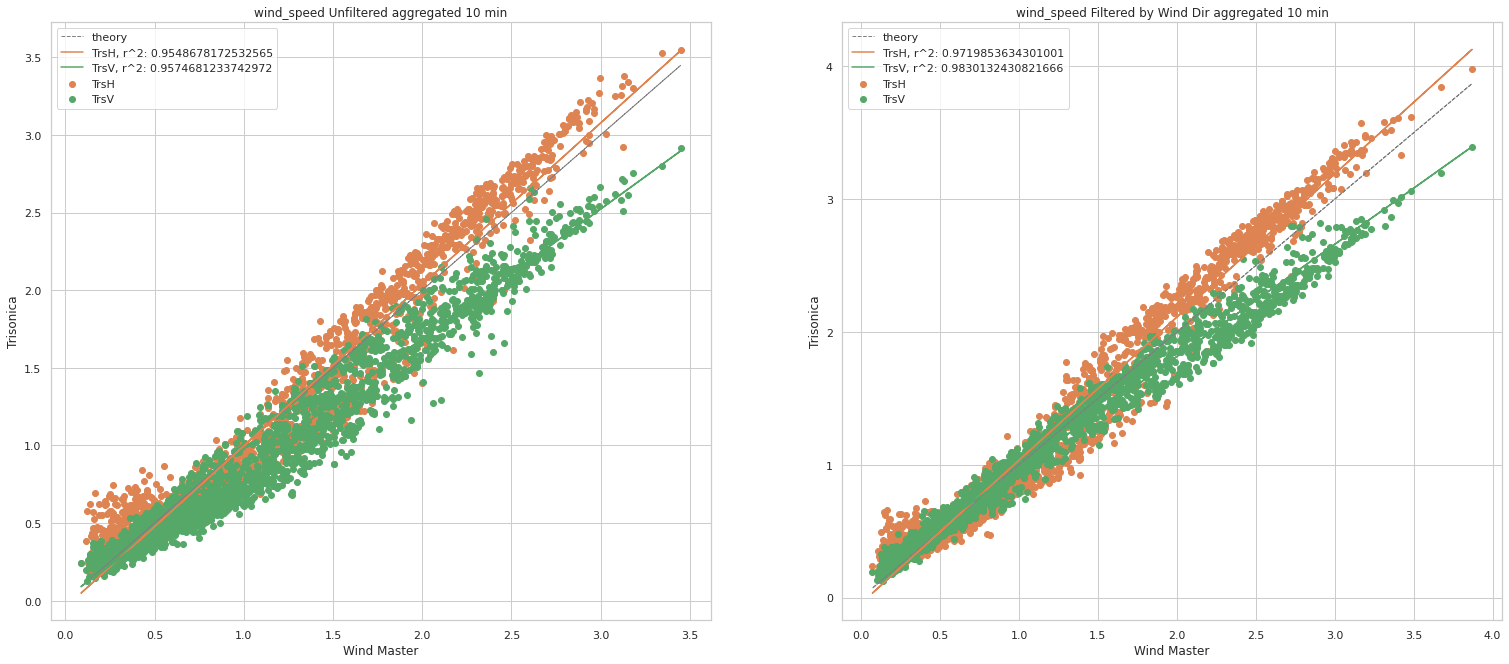

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='wind_speed', plot_info=plot_info_all, title="Unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_dir_10m, col='wind_speed', plot_info=plot_info_all, title="Filtered by Wind Dir aggregated 10 min", ax=axes[1])

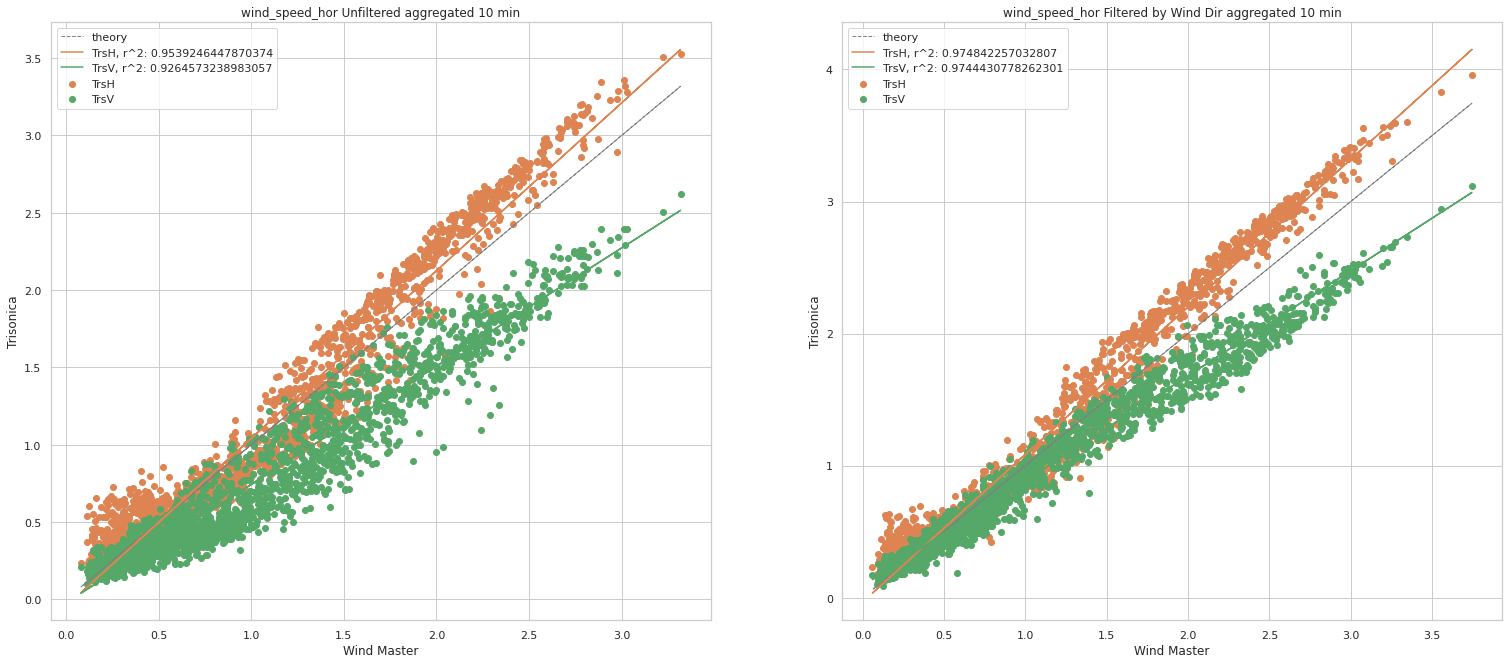

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='wind_speed_hor', plot_info=plot_info_all, title="Unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_dir_10m, col='wind_speed_hor', plot_info=plot_info_all, title="Filtered by Wind Dir aggregated 10 min", ax=axes[1])

##### u TrsV

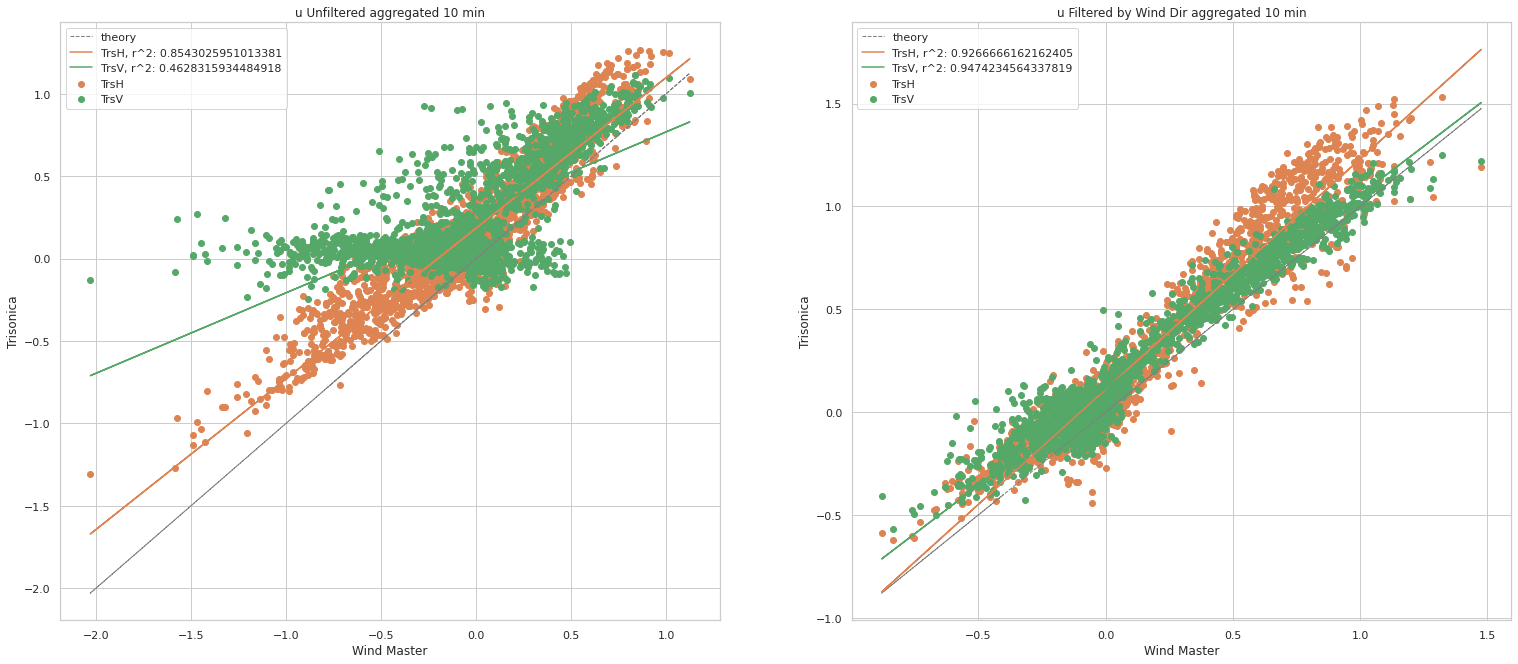

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='u', plot_info=plot_info_all, title="unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_dir_10m, col='u', plot_info=plot_info_all, title="filtered by Wind Dir aggregated 10 min", ax=axes[1])

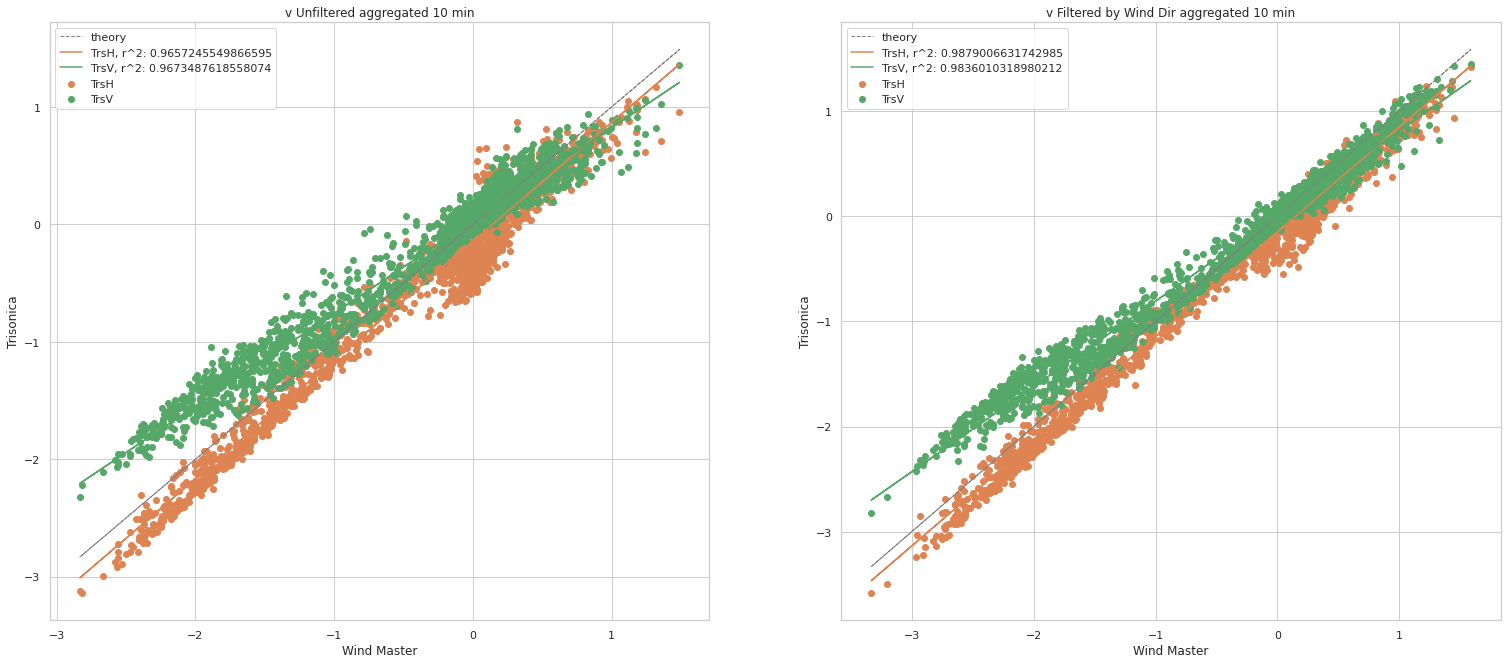

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='v', plot_info=plot_info_all, title="Unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_dir_10m, col='v', plot_info=plot_info_all, title="Filtered by Wind Dir aggregated 10 min", ax=axes[1])

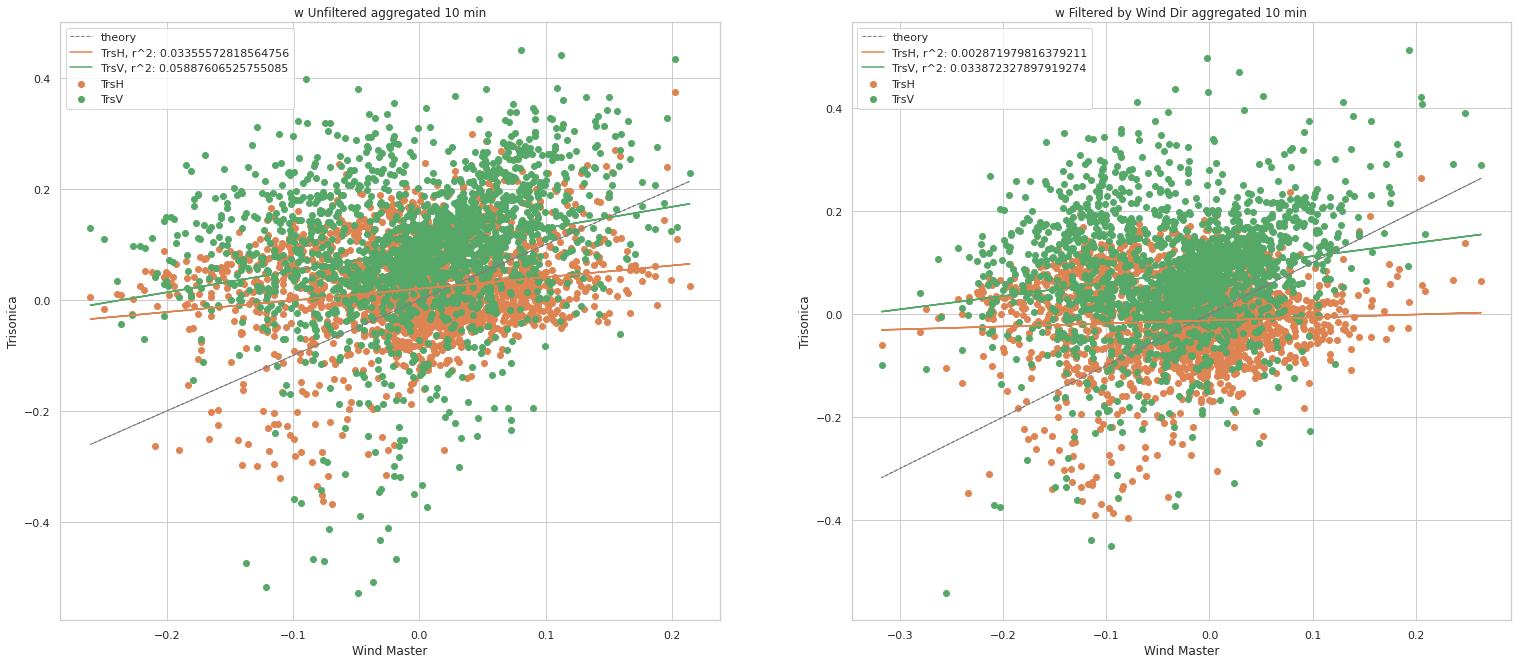

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='w', plot_info=plot_info_all, title="Unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_dir_10m, col='w', plot_info=plot_info_all, title="Filtered by Wind Dir aggregated 10 min", ax=axes[1])

## Filter by AoA 

In [ ]:
aoa_filt.sum() / aoa_filt.count()

0.8218786491045611

AoA is for more than 80% of the time in the right range, so filtering should not change a lot

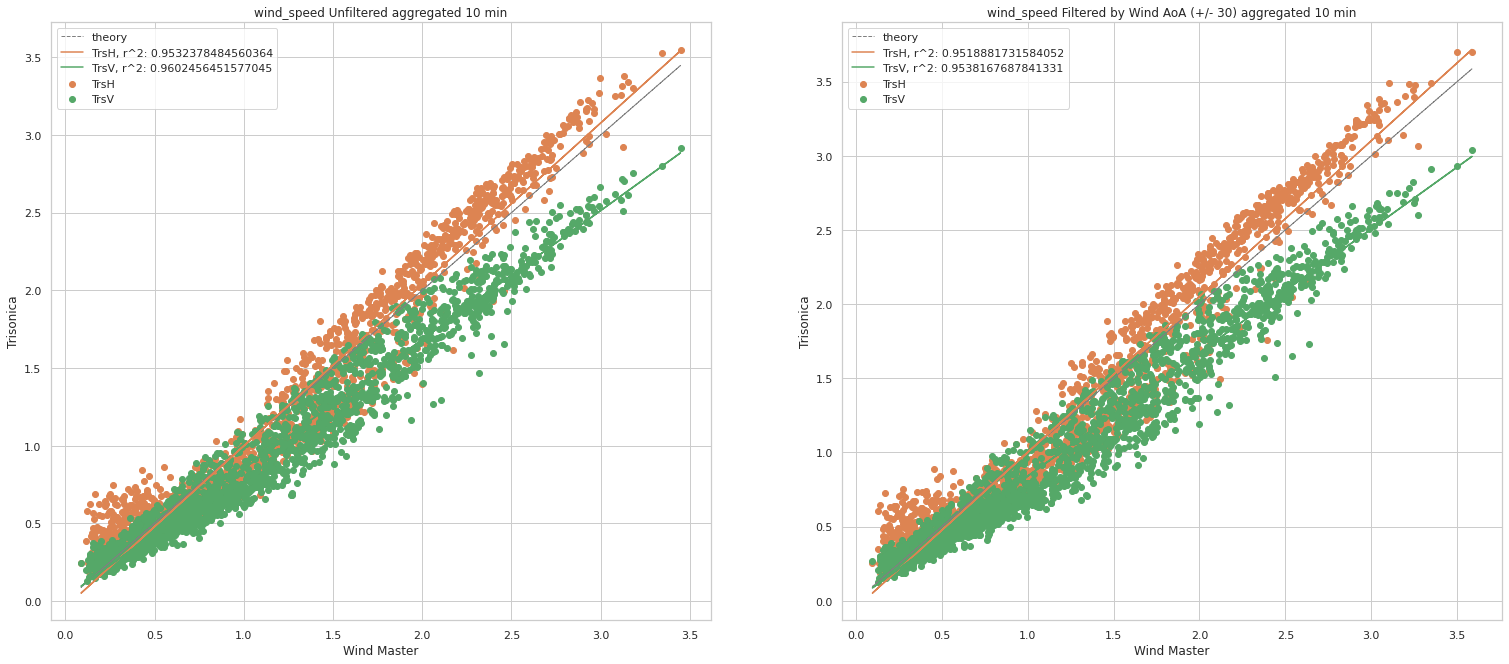

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='wind_speed', plot_info=plot_info_all, title="Unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_aoa_10m, col='wind_speed', plot_info=plot_info_all, title="Filtered by Wind AoA (+/- 30) aggregated 10 min", ax=axes[1])

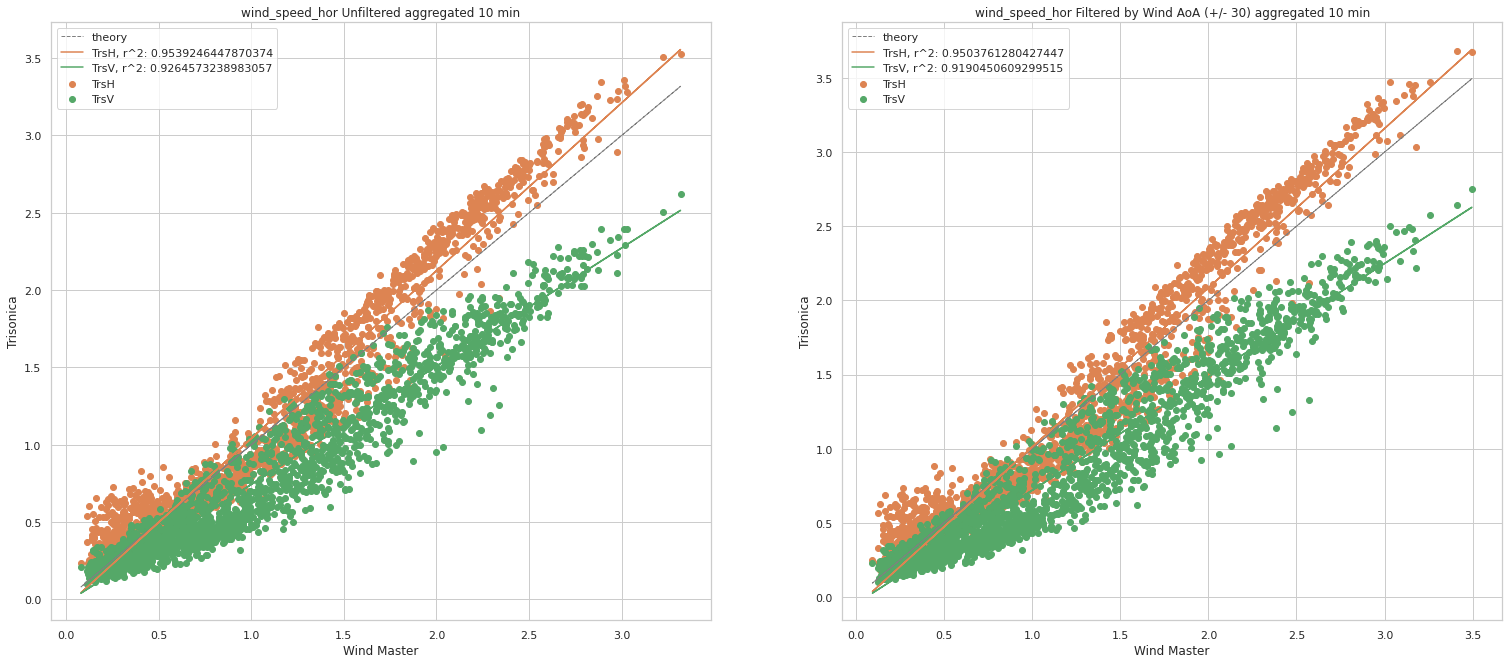

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='wind_speed_hor', plot_info=plot_info_all, title="Unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_aoa_10m, col='wind_speed_hor', plot_info=plot_info_all, title="Filtered by Wind AoA (+/- 30) aggregated 10 min", ax=axes[1])

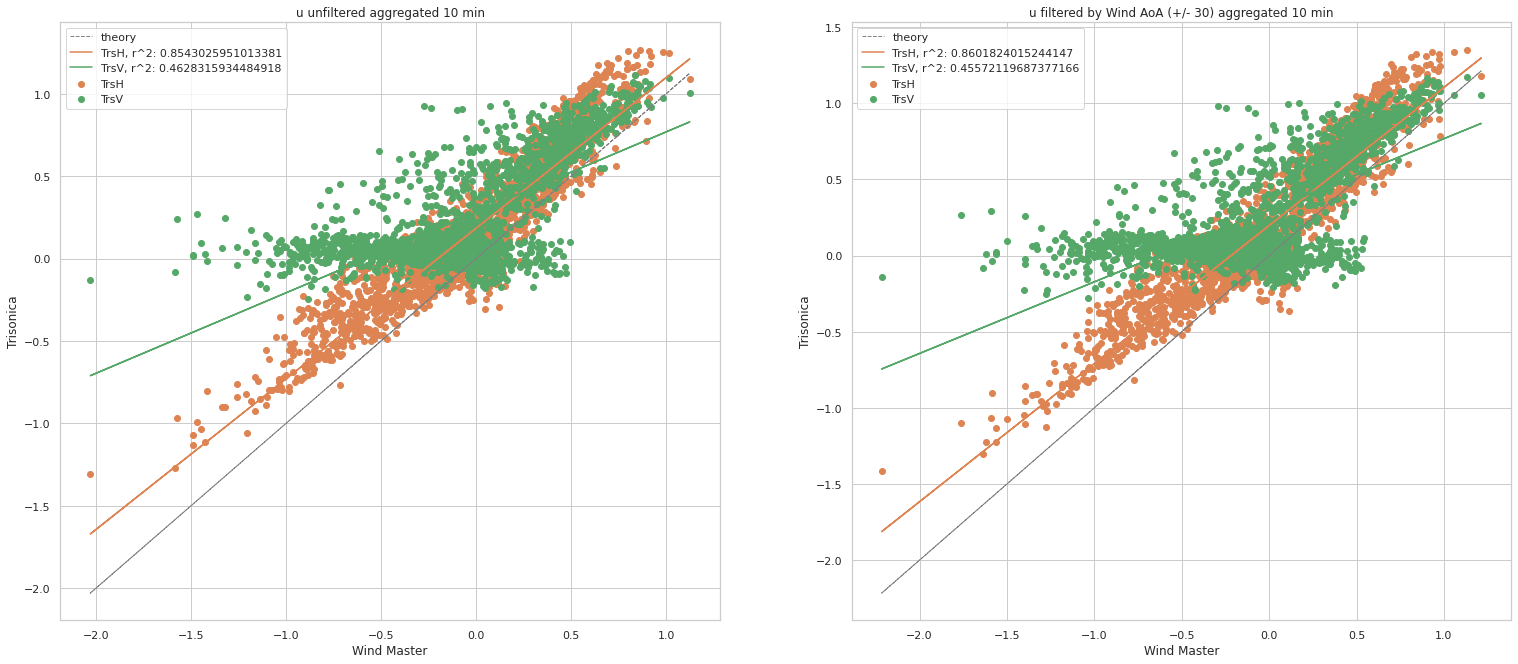

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='u', plot_info=plot_info_all, title="unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_aoa_10m, col='u', plot_info=plot_info_all, title="filtered by Wind AoA (+/- 30) aggregated 10 min", ax=axes[1])

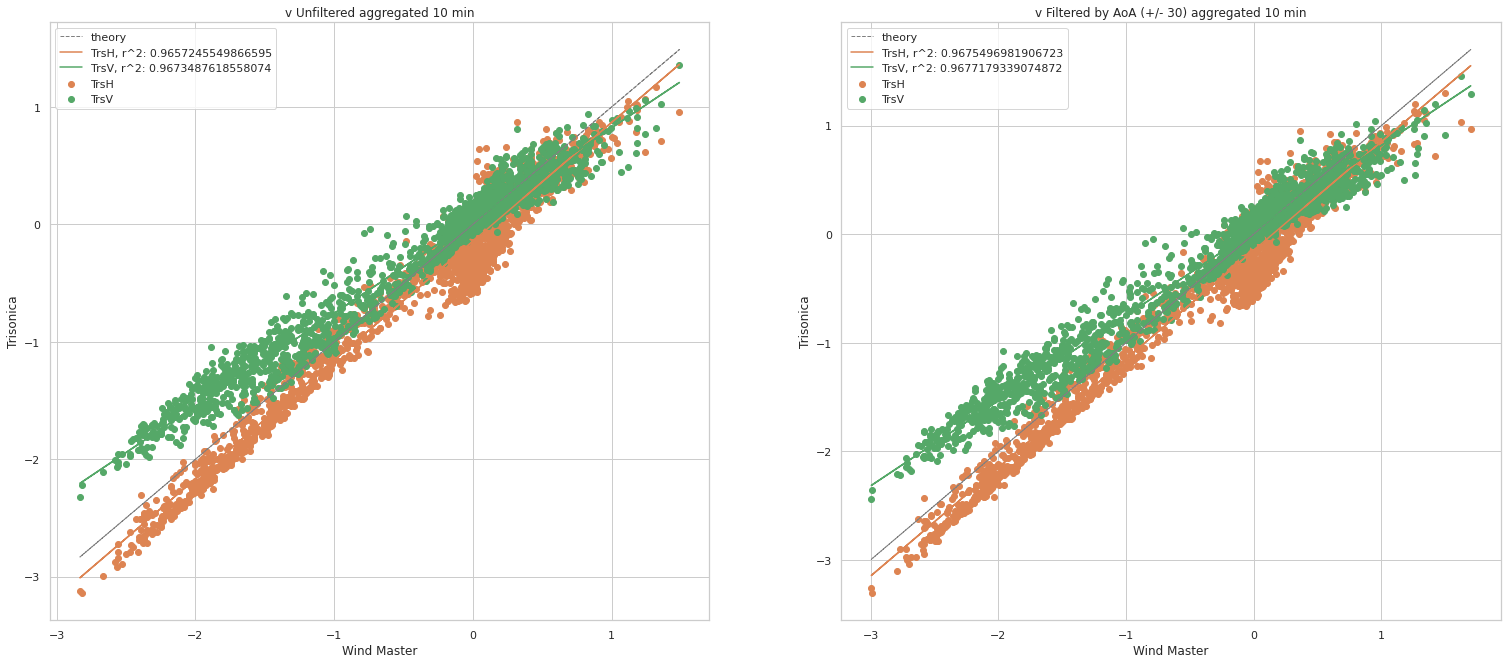

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='v', plot_info=plot_info_all, title="Unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_aoa_10m, col='v', plot_info=plot_info_all, title="Filtered by AoA (+/- 30) aggregated 10 min", ax=axes[1])

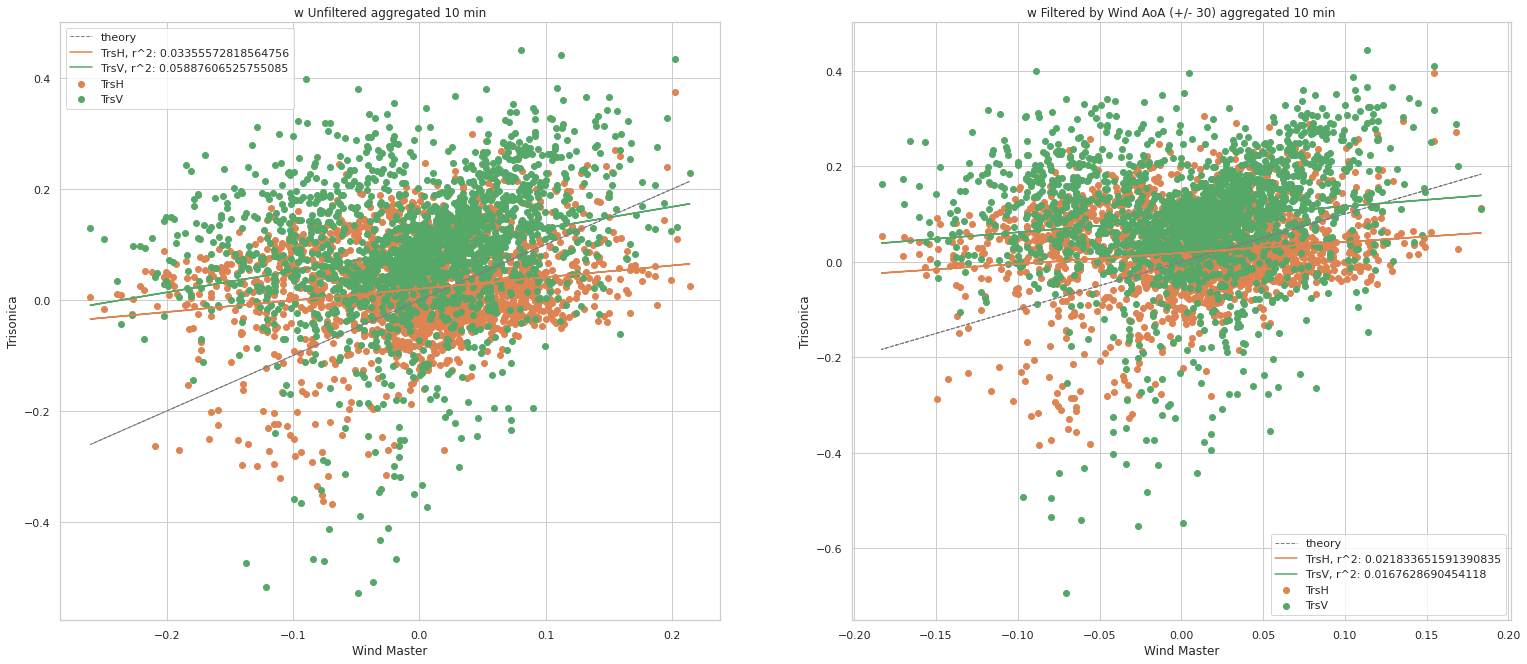

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='w', plot_info=plot_info_all, title="Unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_aoa_10m, col='w', plot_info=plot_info_all, title="Filtered by Wind AoA (+/- 30) aggregated 10 min", ax=axes[1])

## Filter by Wind Dir AND AoA

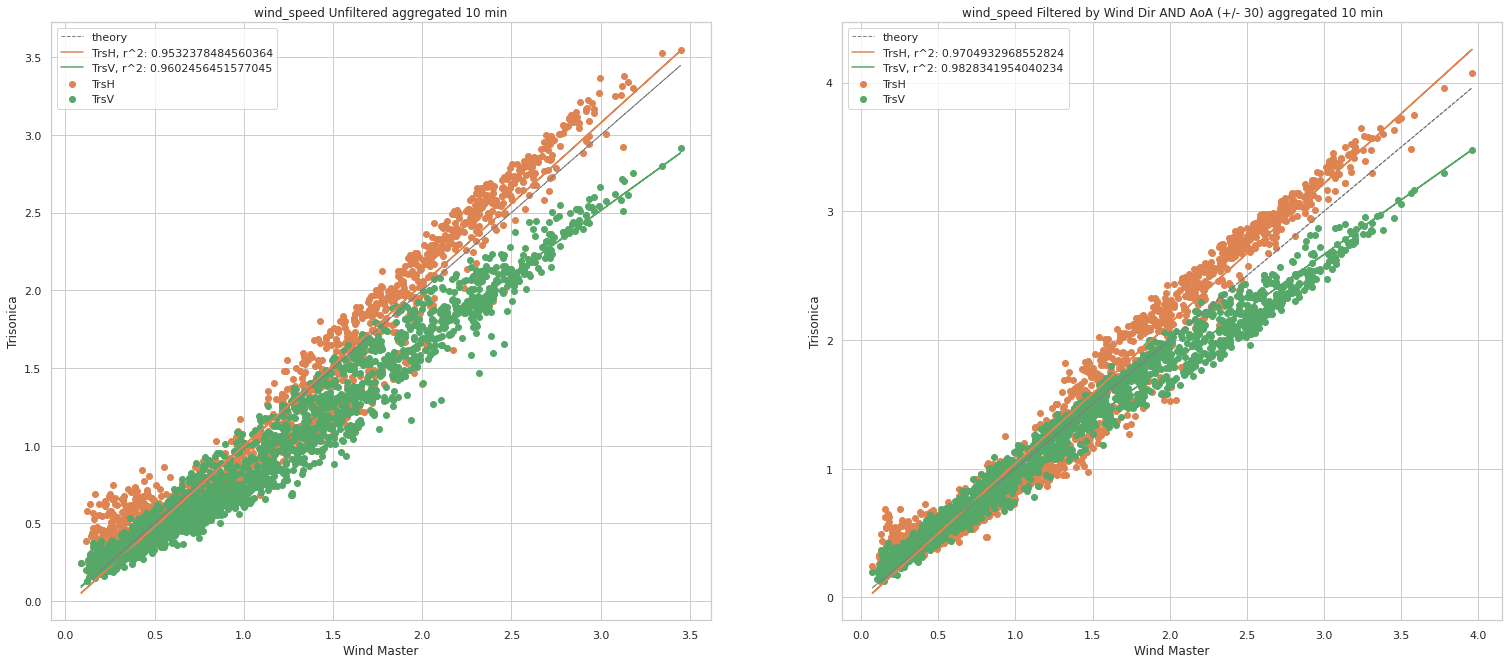

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='wind_speed', plot_info=plot_info_all, title="Unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_aoa_and_dir_10m, col='wind_speed', plot_info=plot_info_all, title="Filtered by Wind Dir AND AoA (+/- 30) aggregated 10 min", ax=axes[1])

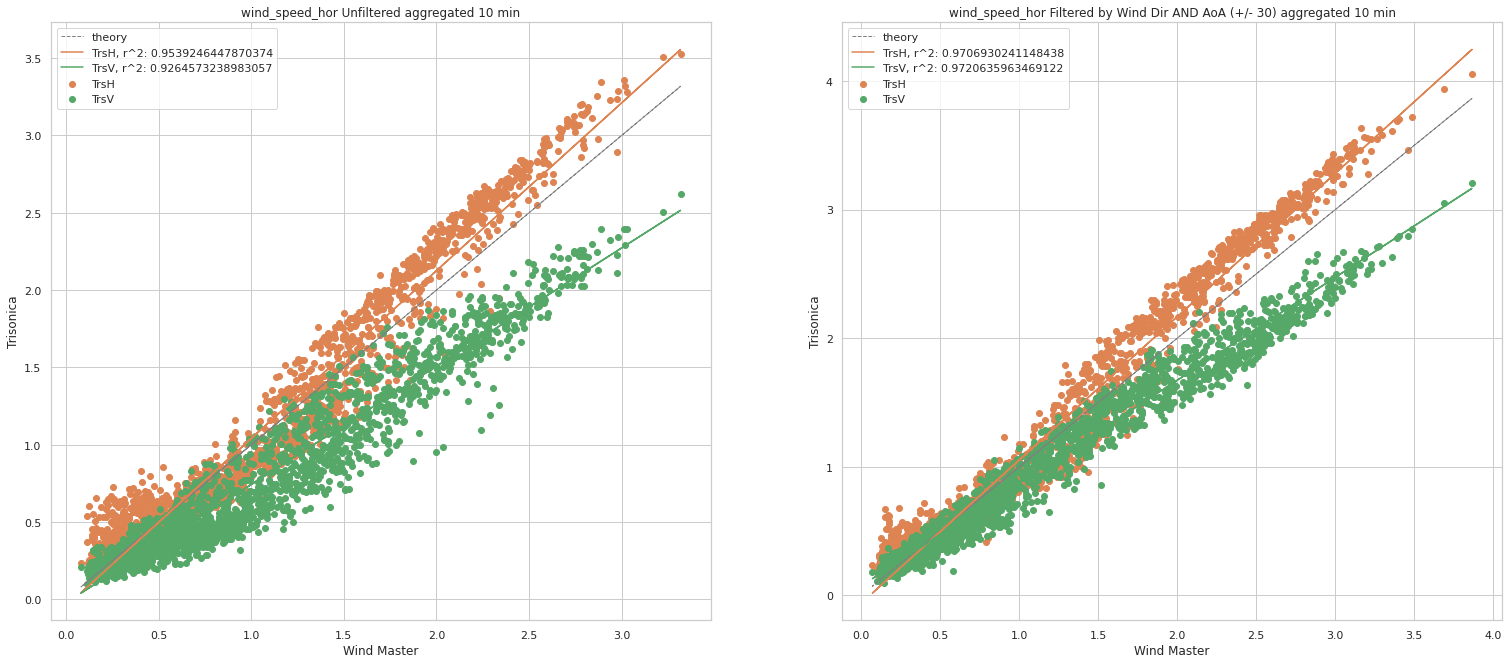

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='wind_speed_hor', plot_info=plot_info_all, title="Unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_aoa_and_dir_10m, col='wind_speed_hor', plot_info=plot_info_all, title="Filtered by Wind Dir AND AoA (+/- 30) aggregated 10 min", ax=axes[1])

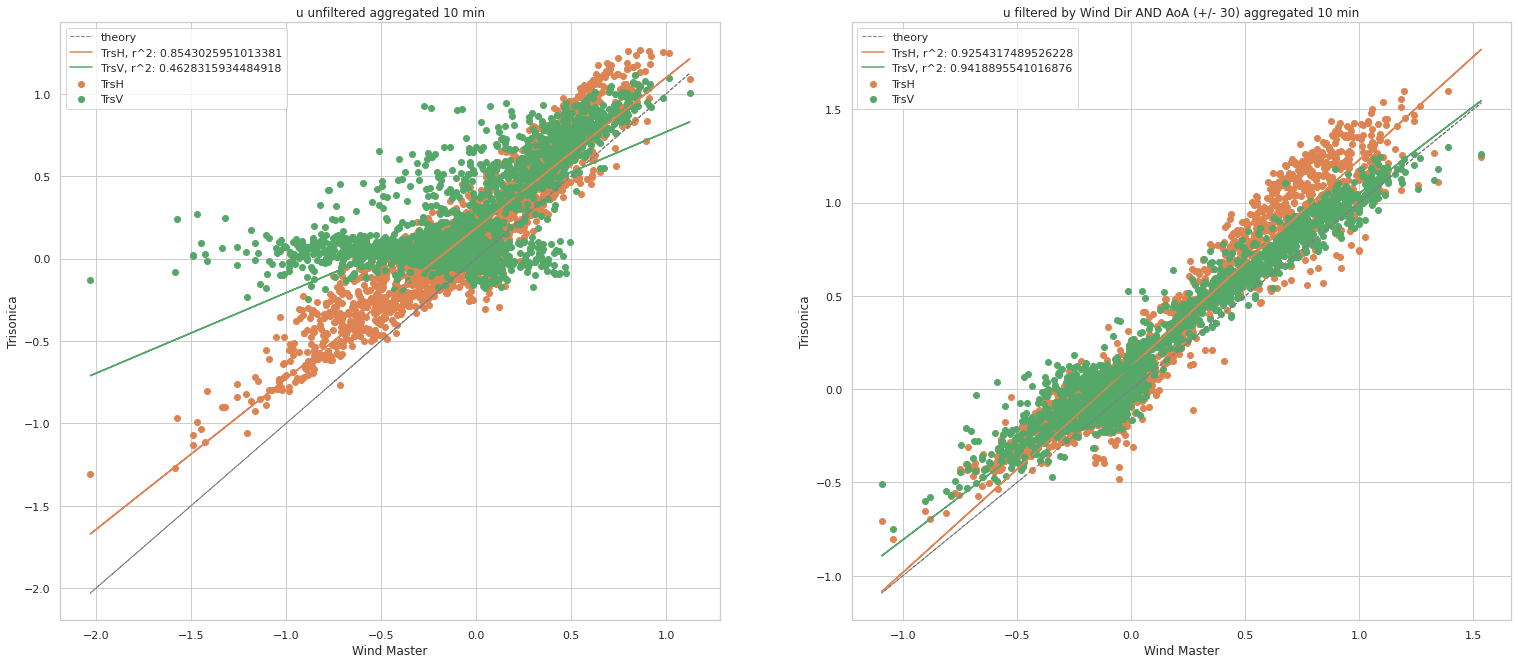

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='u', plot_info=plot_info_all, title="unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_aoa_and_dir_10m, col='u', plot_info=plot_info_all, title="filtered by Wind Dir AND AoA (+/- 30) aggregated 10 min", ax=axes[1])

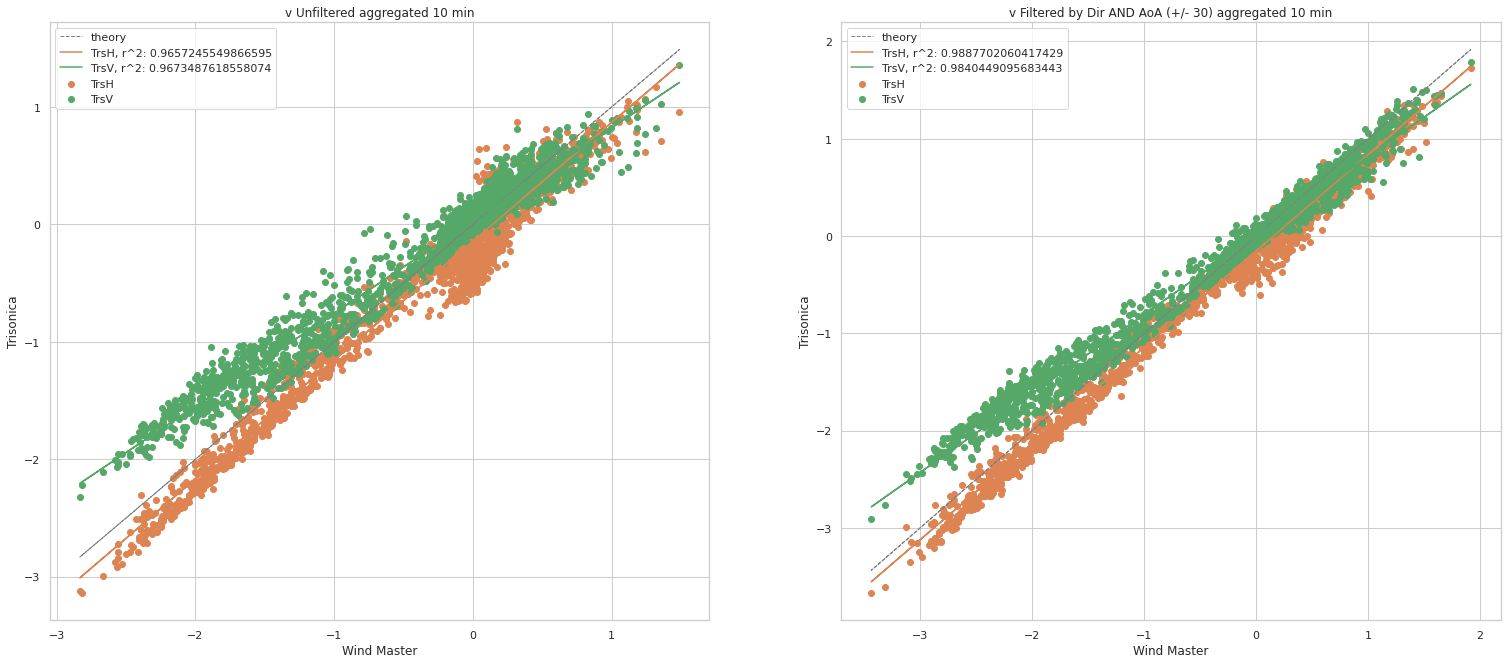

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='v', plot_info=plot_info_all, title="Unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_aoa_and_dir_10m, col='v', plot_info=plot_info_all, title="Filtered by Dir AND AoA (+/- 30) aggregated 10 min", ax=axes[1])

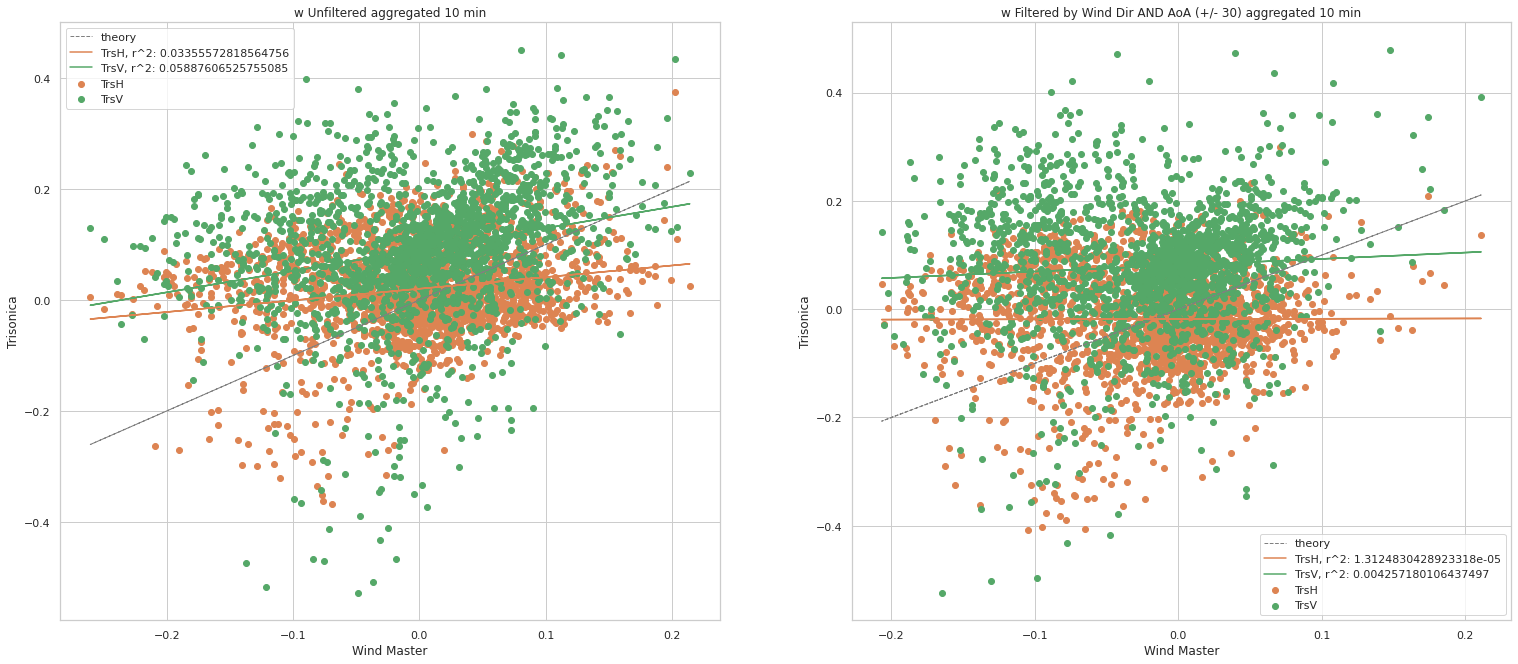

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(unf_10m, col='w', plot_info=plot_info_all, title="Unfiltered aggregated 10 min", ax=axes[0])
plot_one_scatter(filt_aoa_and_dir_10m, col='w', plot_info=plot_info_all, title="Filtered by Wind Dir AND AoA (+/- 30) aggregated 10 min", ax=axes[1])

## Fluxes 

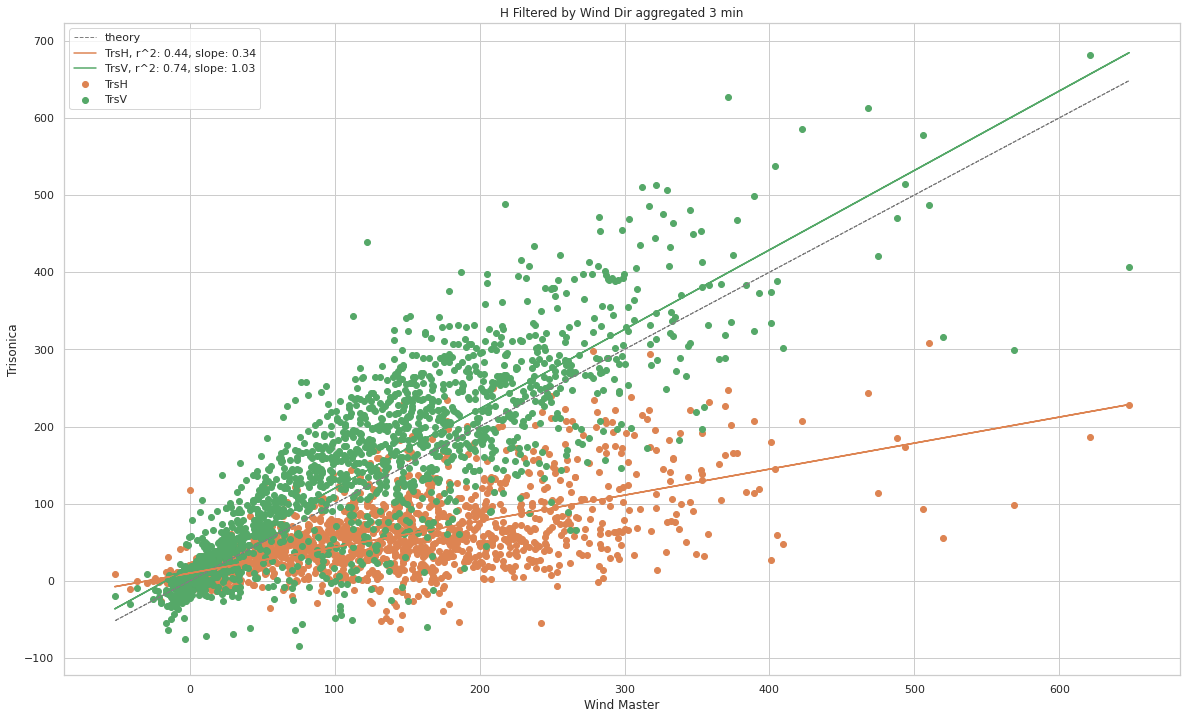

In [ ]:
plot_one_scatter(filt_dir_ep, col='H', plot_info=plot_info_all, title="Filtered by Wind Dir aggregated 3 min")

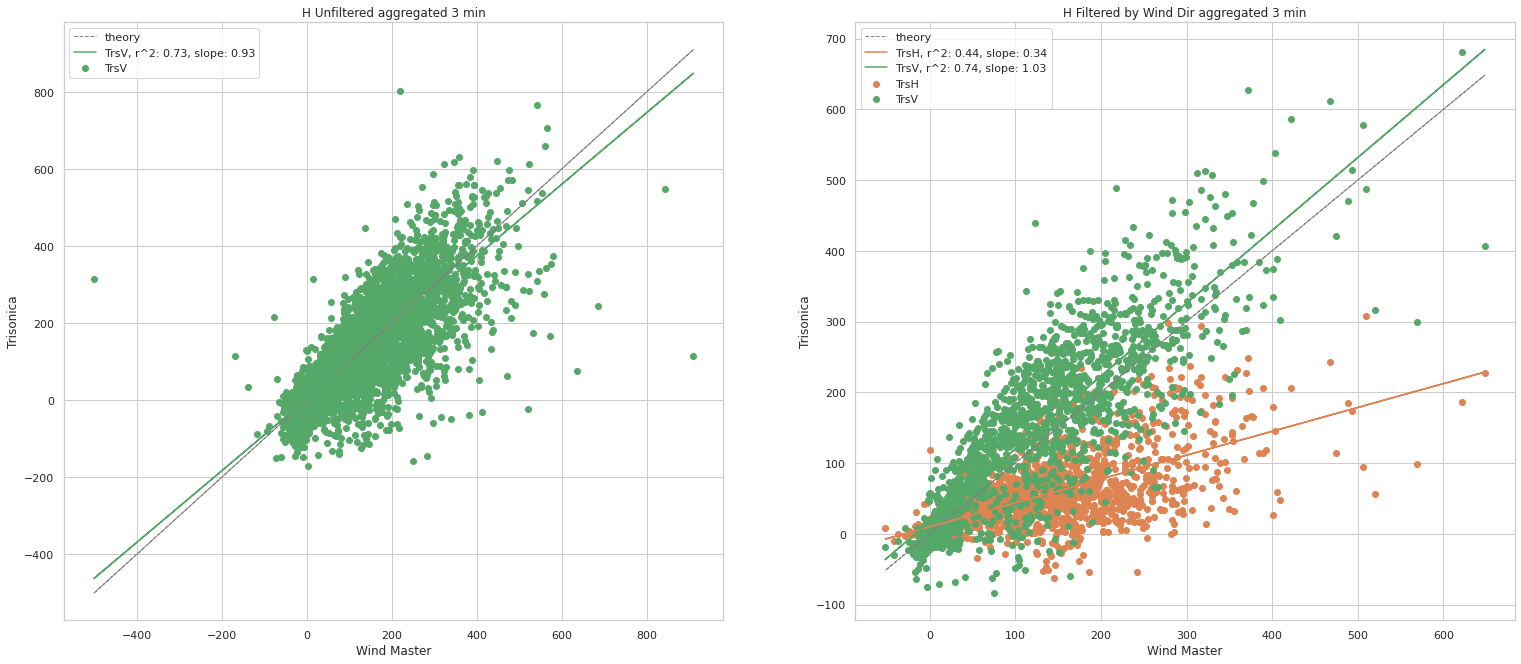

In [ ]:
axes=get_ax(1,2, figsize=(26,11)) 
plot_one_scatter(ep_3m, col='H', plot_info=plot_info_m7, title="Unfiltered aggregated 3 min", ax=axes[0])
plot_one_scatter(filt_dir_ep, col='H', plot_info=plot_info_all, title="Filtered by Wind Dir aggregated 3 min", ax=axes[1])

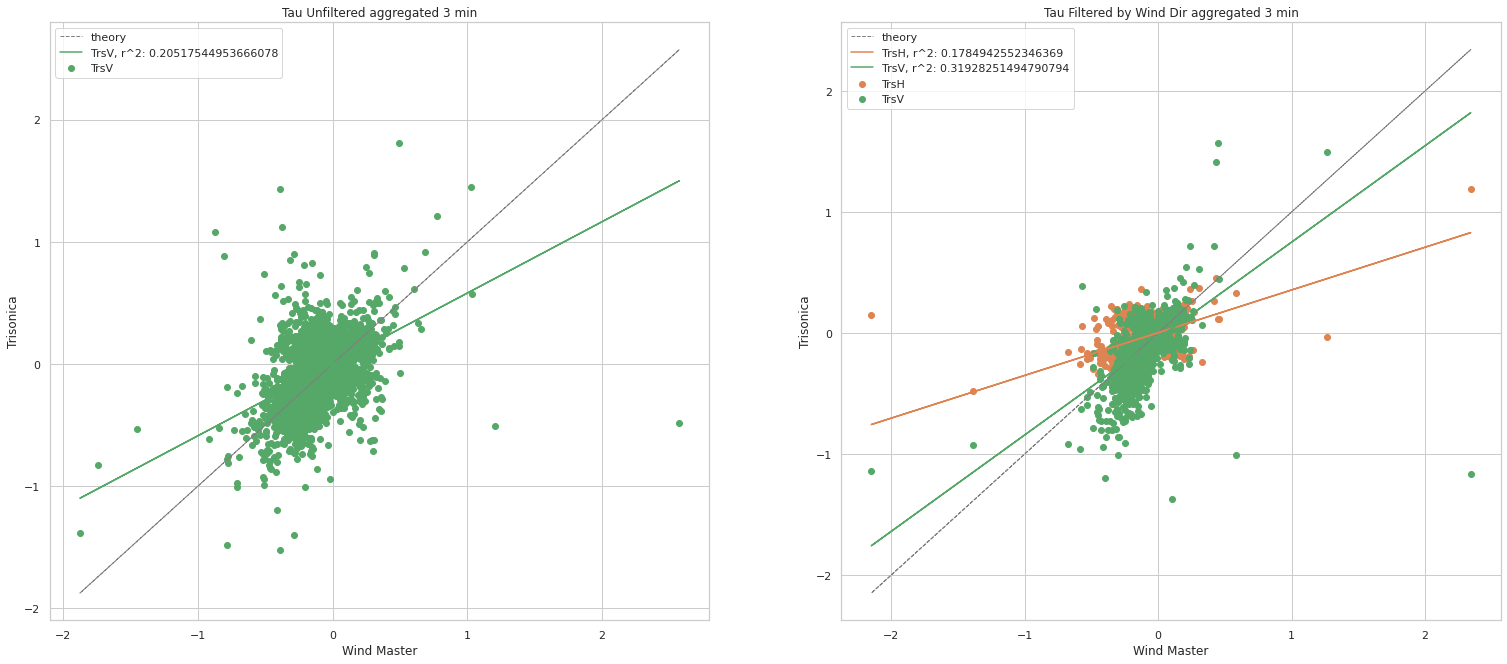

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(ep_3m, col='Tau', plot_info=plot_info_m7, title="Unfiltered aggregated 3 min", ax=axes[0])
plot_one_scatter(filt_dir_ep, col='Tau', plot_info=plot_info_all, title="Filtered by Wind Dir aggregated 3 min", ax=axes[1])

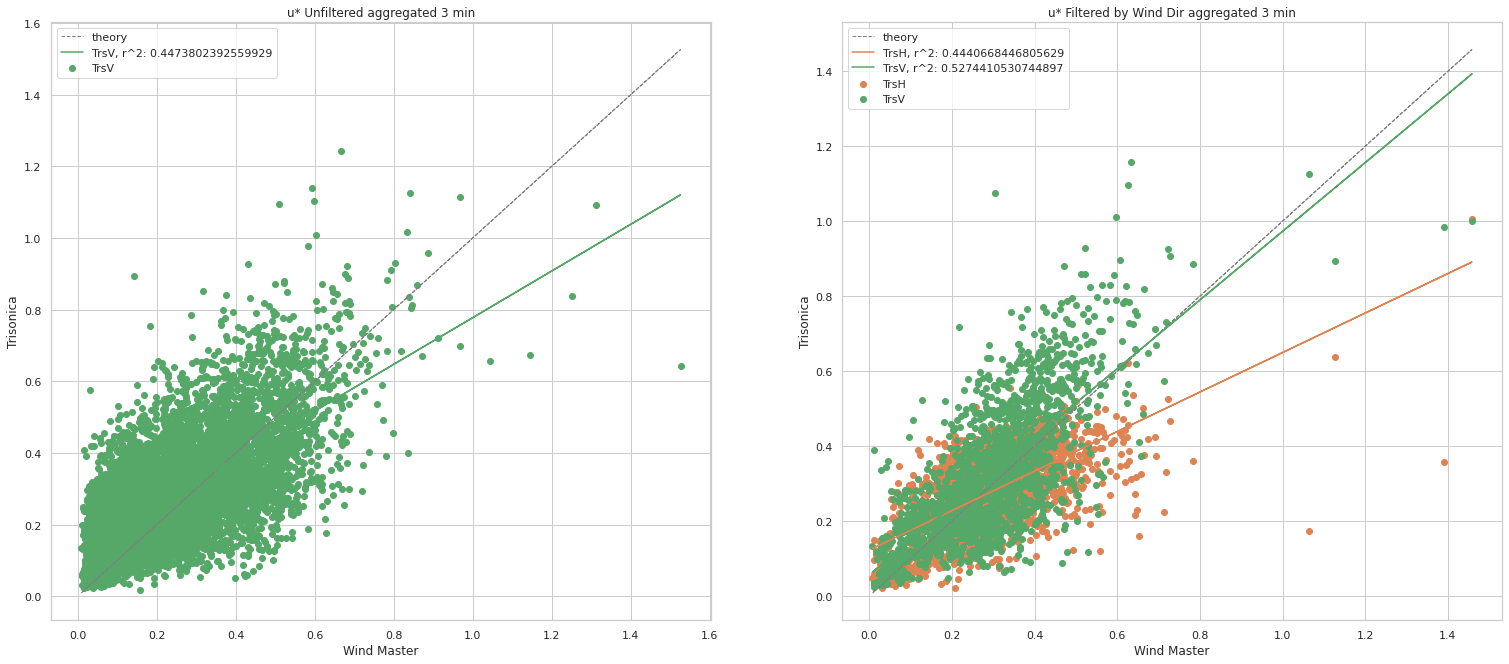

In [ ]:
axes=get_ax(1,2, figsize=(26,11))
plot_one_scatter(ep_3m, col='u*', plot_info=plot_info_m7, title="Unfiltered aggregated 3 min", ax=axes[0])
plot_one_scatter(filt_dir_ep, col='u*', plot_info=plot_info_all, title="Filtered by Wind Dir aggregated 3 min", ax=axes[1])

my fluxes

In [ ]:
def add_H_flux(df, interval):
    H =[]
    res = df.resample(interval)
    for i, g in res:
        H.append(g.w.cov(g.t))
    ret = res.mean()
    ret['H'] = H
    return ret

In [ ]:
def add_tau_flux(df, interval):
    tau =[]
    res = df.resample(interval)
    for i, g in res:
        tau.append(g.w.cov(g.t))
    ret = res.mean()
    ret['Tau'] = tau
    return ret

In [ ]:
add_H_flux(test, '30min')['H']

2020-08-24 00:00:00   -0.015980
2020-08-24 00:30:00   -0.023333
2020-08-24 01:00:00    0.009023
2020-08-24 01:30:00   -0.005173
2020-08-24 02:00:00   -0.008614
2020-08-24 02:30:00   -0.009192
2020-08-24 03:00:00   -0.014506
2020-08-24 03:30:00   -0.013334
2020-08-24 04:00:00   -0.032847
2020-08-24 04:30:00   -0.006386
2020-08-24 05:00:00   -0.014526
2020-08-24 05:30:00   -0.011787
2020-08-24 06:00:00   -0.010808
2020-08-24 06:30:00   -0.012472
2020-08-24 07:00:00   -0.001746
2020-08-24 07:30:00   -0.016957
2020-08-24 08:00:00    0.003268
2020-08-24 08:30:00    0.043140
2020-08-24 09:00:00    0.087147
2020-08-24 09:30:00    0.114311
2020-08-24 10:00:00    0.087477
2020-08-24 10:30:00    0.163378
2020-08-24 11:00:00    0.129187
2020-08-24 11:30:00    0.133583
2020-08-24 12:00:00    0.242328
2020-08-24 12:30:00    0.268420
2020-08-24 13:00:00    0.100377
2020-08-24 13:30:00    0.228585
2020-08-24 14:00:00    0.300258
2020-08-24 14:30:00    0.285490
2020-08-24 15:00:00    0.257683
2020-08-

In [ ]:
test.w.cov(test.t)

-0.11095625836472037

In [ ]:
test = wm1.loc['2020-08-24 00:00':'2020-08-24 23:59']

In [ ]:
test

u     v     w      t   wind_dir  wind_speed  \
2020-08-24 05:00:00.000 -1.03  0.46  0.33  22.10  24.065632    1.175330   
2020-08-24 05:00:00.100 -0.87  0.55  0.16  22.07  32.300416    1.041633   
2020-08-24 05:00:00.200 -0.84  0.61  0.13  22.09  35.986796    1.046231   
2020-08-24 05:00:00.300 -0.82  0.62  0.14  22.09  37.092837    1.037497   
2020-08-24 05:00:00.400 -0.76  0.51  0.15  22.09  33.863691    0.927470   
...                       ...   ...   ...    ...        ...         ...   
2020-08-24 00:29:59.500 -1.20  0.24  0.24  24.50  11.309932    1.247077   
2020-08-24 00:29:59.600 -1.09  0.24  0.25  24.52  12.417446    1.143766   
2020-08-24 00:29:59.700 -1.10  0.14  0.20  24.56   7.253195    1.126765   
2020-08-24 00:29:59.800 -1.10  0.20  0.22  24.50  10.304846    1.139474   
2020-08-24 00:29:59.900 -1.12  0.17  0.23  24.50   8.630802    1.155941   

                         angle_attack  wind_speed_hor  
2020-08-24 05:00:00.000     16.306302        1.128051  
2020-08-24 05:00:00.100      8.835895        1.029272  
2020-08-24 05:00:00.200      7.137764        1.038123  
2020-08-24 05:00:00.300      7.755159        1.028008  
2020-08-24 05:00:00.400      9.307347        0.915260  
...                               ...             ...  
2020-08-24 00:29:59.500     11.095803        1.223765  
2020-08-24 00:29:59.600     12.625422        1.116109  
2020-08-24 00:29:59.700     10.224132        1.108873  
2020-08-24 00:29:59.800     11.132095        1.118034  
2020-08-24 00:29:59.900     11.476855        1.132828  

[864000 rows x 8 columns]

In [ ]:
def first(x): print(x[0])

## Test

(array([9.66183575e-04, 3.86473430e-03, 1.83574879e-02, 5.41062802e-02,
        1.47826087e-01, 3.28985507e-01, 5.47342995e-01, 8.36714976e-01,
        9.57487923e-01, 1.00000000e+00]),
 array([0.47633333, 0.52865   , 0.58096667, 0.63328333, 0.6856    ,
        0.73791667, 0.79023333, 0.84255   , 0.89486667, 0.94718333,
        0.9995    ]),
 <BarContainer object of 10 artists>)

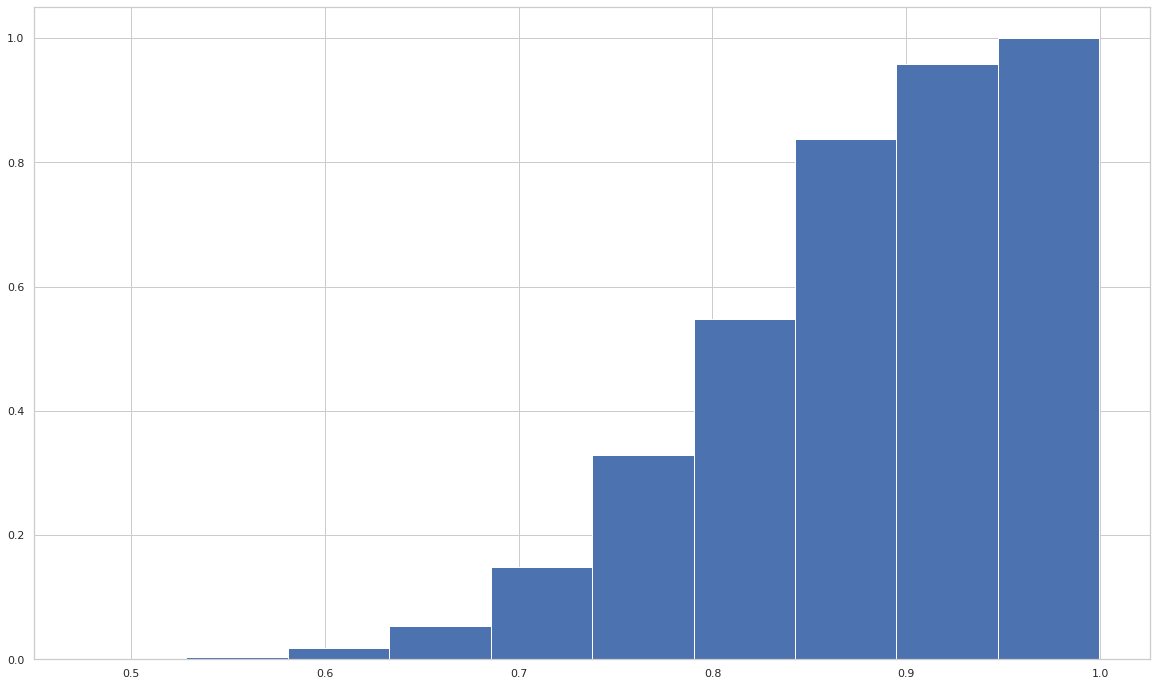

In [ ]:
get_ax()
plt.hist(aoa_filt.resample('10min').sum() / (10*60*10), cumulative=True, density=True)

(array([0.0057971 , 0.02753623, 0.07681159, 0.2115942 , 0.38695652,
        0.54637681, 0.77971014, 0.94492754, 0.98405797, 1.        ]),
 array([0.63022222, 0.66481667, 0.69941111, 0.73400556, 0.7686    ,
        0.80319444, 0.83778889, 0.87238333, 0.90697778, 0.94157222,
        0.97616667]),
 <BarContainer object of 10 artists>)

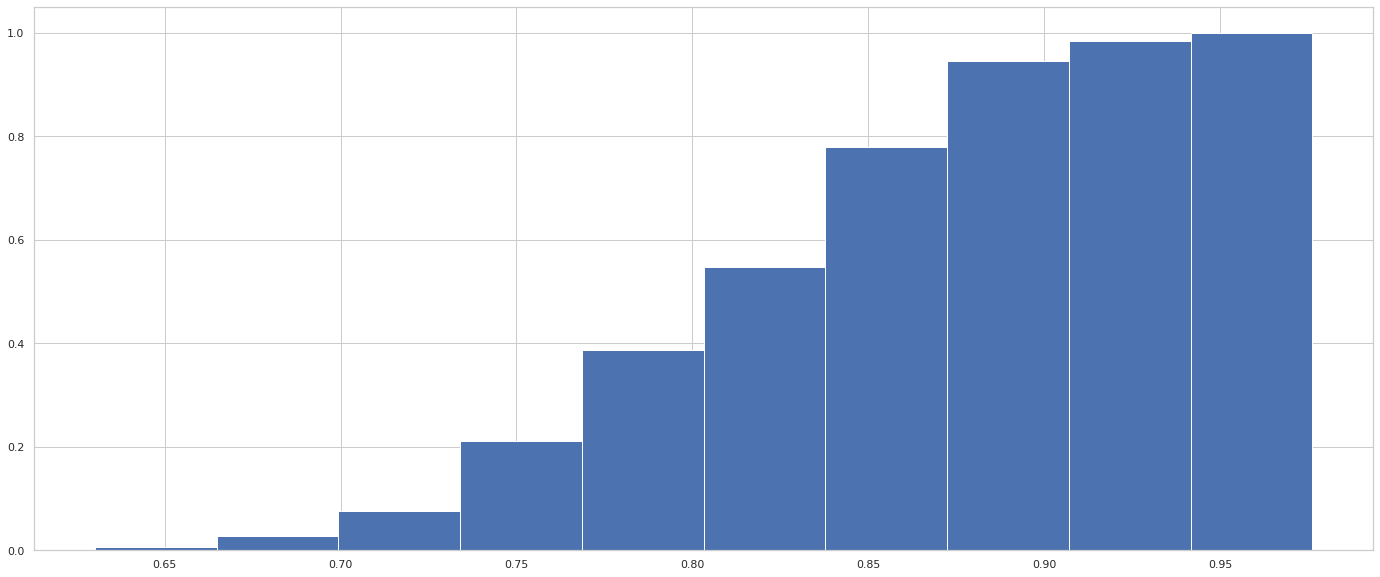

In [ ]:
get_ax()
plt.hist(aoa_filt.resample('30min').sum() / (10*60*30), cumulative=True, density=True)

(array([0.01846799, 0.05540396, 0.27701982, 0.68331556, 1.79139484,
        3.46274776, 4.1737653 , 5.53116242, 2.30849851, 0.81259147]),
 array([0.47633333, 0.52865   , 0.58096667, 0.63328333, 0.6856    ,
        0.73791667, 0.79023333, 0.84255   , 0.89486667, 0.94718333,
        0.9995    ]),
 <BarContainer object of 10 artists>)

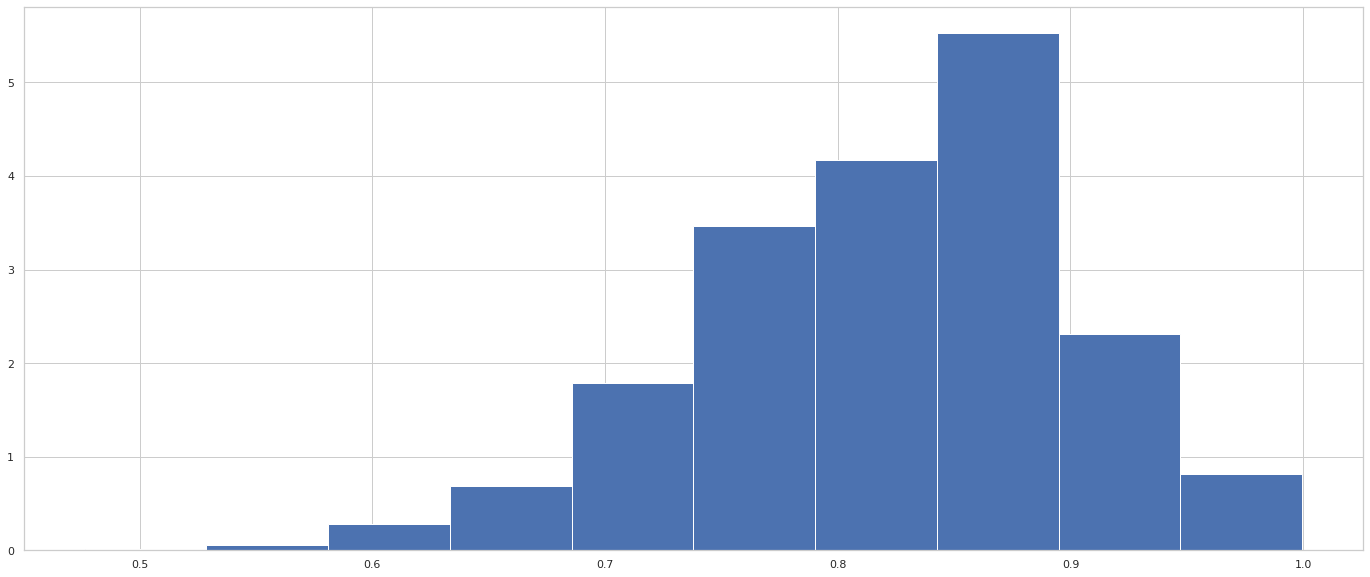

In [ ]:
get_ax()
plt.hist(aoa_filt.resample('10min').sum() / (10*60*10), cumulative=False, density=True)

In [ ]:
dfs = [df[wm1.wind_speed>.4].resample('5min').mean().dropna().pipe(add_wind_dir) for df in [wm1, TrsH, TrsV]]

/home/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


/home/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='wind_dir'>

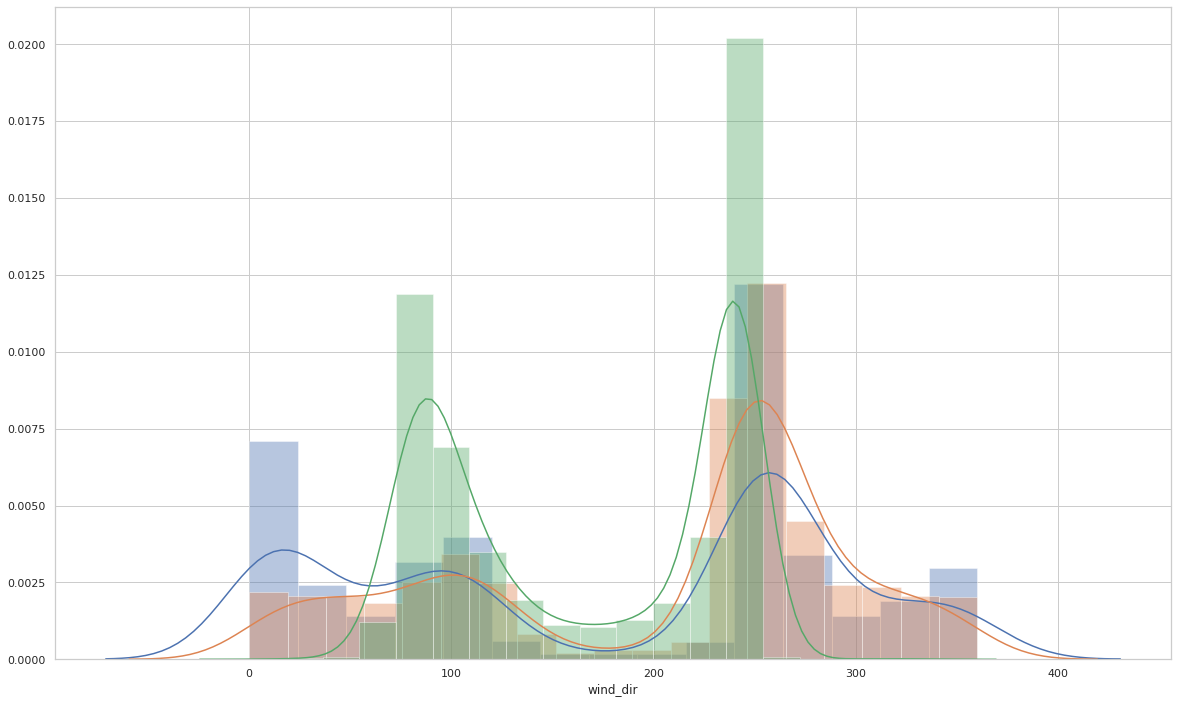

In [ ]:
get_ax()
sns.distplot(wm1[wm1.wind_speed>.4].resample('5min').mean().dropna().pipe(add_wind_dir).wind_dir)
sns.distplot(TrsH[wm1.wind_speed>.4].resample('5min').mean().dropna().pipe(add_wind_dir).wind_dir)
sns.distplot(TrsV[wm1.wind_speed>.4].resample('5min').mean().dropna().pipe(add_wind_dir).wind_dir)

Text(0.5, 1.0, 'Wind Direction at 5 mins')

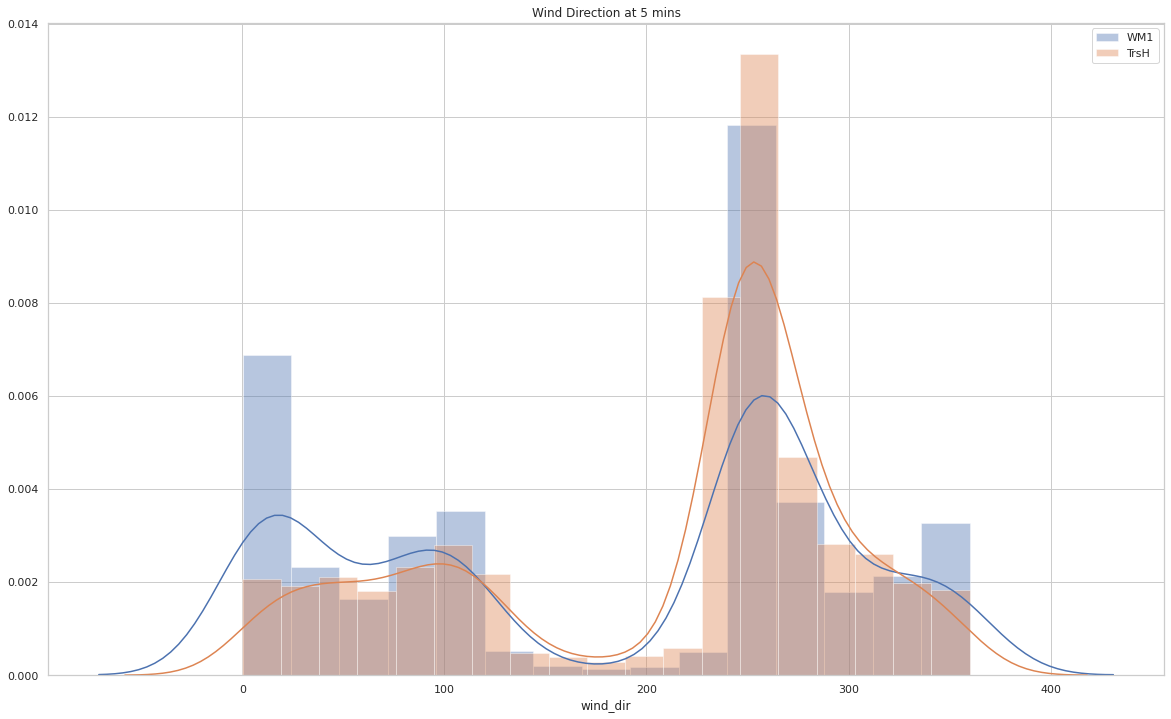

In [ ]:
get_ax()
sns.distplot(wm1.resample('5min').mean().dropna().pipe(add_wind_dir).wind_dir, **plot_info_all[0])
sns.distplot(TrsH.resample('5min').mean().dropna().pipe(add_wind_dir).wind_dir, **plot_info_all[1])
plt.legend()
plt.title("Wind Direction at 5 mins")

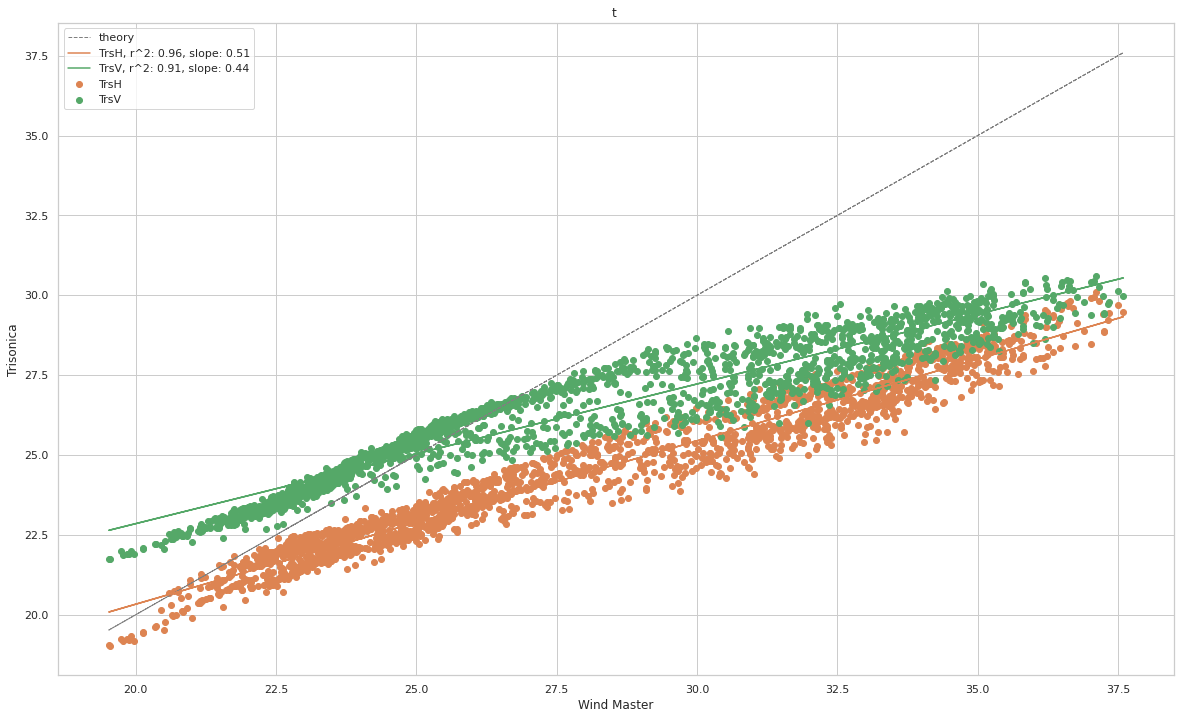

In [ ]:
plot_one_scatter(unf_10m, col='t', plot_info=plot_info_all)